# Exploratory Model Development
**Author:** Jacob Kvasnicka <br>
**Date:** February 4, 2025

https://dept.stat.lsa.umich.edu/~kshedden/stats504/topics/mixed/
This is often referred to as a “random intercepts model”, with the random intercepts 
θ
i
θ 
i
​
  reflecting the net effect of all unobserved covariates influencing all observed values in a particular group.

  The value 
r
r defined above is known as the “intraclass correlation coefficient”, or “ICC”. It is a measure of how strongly the group membership associates with the value of the response variable 
y
i
j
y 
ij
​
  . The ICC falls between zero and one. If the ICC is equal to zero, the group membership is totally unrelated to the response value. If the ICC is equal to one, the response variable is entirely determined by the group membership.

In [1]:
# TODO: Try modeling the target variable per chemical only. May eliminate non-detects.
# Could frame this as a sensitivity analysis. We tried NAICS, but no-go.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupKFold, train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

# Seed for reproducibility
np.random.seed(42)

from config_management import UnifiedConfiguration
import data_management
import plot

config = UnifiedConfiguration()

## Exploratory Analysis

In [3]:
ec_for_naics = data_management.read_targets(config.path['target_dir'])
sorted_naics_levels = config.cehd['naics_levels']
ec_for_naics = {k : ec_for_naics[k] for k in sorted_naics_levels}

opera_features = pd.read_parquet(config.path['opera_features_file'])

Text(0.5, 0, '$\\log_{10}(\\mathit{EC})$ [mg$\\cdot$(m$^3$)$^{-1}$]')

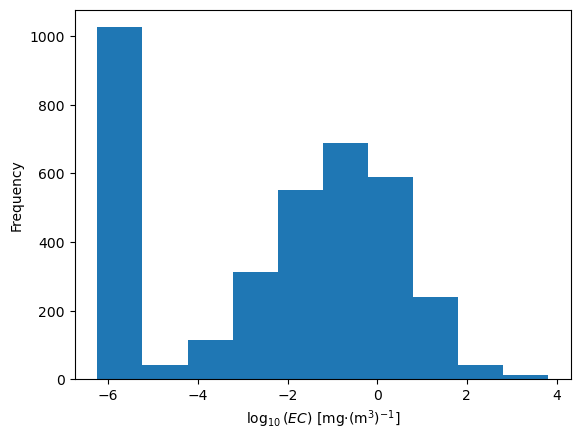

In [4]:
ax = plot.preprocess_target(ec_for_naics['sector']).plot.hist()
ax.set_xlabel(r'$\log_{10}(\mathit{EC})$ [mg$\cdot$(m$^3$)$^{-1}$]')

In [5]:
correlation_features = pd.DataFrame({
    'KOA_pred': np.log10(opera_features['KOA_pred']),
    'VP_pred': np.log10(opera_features['VP_pred']),
    'HL_pred': np.log10(opera_features['HL_pred']),
    'P_pred': np.log10(opera_features['P_pred']),
    'WS_pred': np.log10(opera_features['WS_pred']),
    'MolWeight': np.log10(opera_features['MolWeight']),
    'TopoPolSurfAir': opera_features['TopoPolSurfAir'],
    'nbRotBd_discrete': opera_features['nbRotBd_discrete']
})

label_for_feature = {
    'KOA_pred': r'$\log_{10}(K_{oa})$',
    'VP_pred': r'$\log_{10}(VP)$ (mmHg)',
    'HL_pred': r'$\log_{10}(HL)$ (atm-m$^3$/mol)',
    'P_pred': r'$\log_{10}(P)$',
    'WS_pred': r'$\log_{10}(WS)$ (mol/L)',
    'MolWeight': r'$\log_{10}(Molecular Weight)$',
    'TopoPolSurfAir': r'TopoPolSurfAir (A$^2$)',
    'nbRotBd_discrete': r'nbRotBd_discrete'
}

In [6]:
correlation_features.corr()

KOA_pred   VP_pred   HL_pred    P_pred   WS_pred  MolWeight  \
KOA_pred          1.000000 -0.825001 -0.500074  0.340840 -0.535916   0.745217   
VP_pred          -0.825001  1.000000  0.594550 -0.105874  0.391207  -0.625031   
HL_pred          -0.500074  0.594550  1.000000  0.279447 -0.093457  -0.244245   
P_pred            0.340840 -0.105874  0.279447  1.000000 -0.698900   0.439703   
WS_pred          -0.535916  0.391207 -0.093457 -0.698900  1.000000  -0.663613   
MolWeight         0.745217 -0.625031 -0.244245  0.439703 -0.663613   1.000000   
TopoPolSurfAir    0.319746 -0.498018 -0.583297 -0.350415  0.063479   0.458830   
nbRotBd_discrete  0.340080 -0.185394 -0.043333  0.285246 -0.317420   0.580362   

                  TopoPolSurfAir  nbRotBd_discrete  
KOA_pred                0.319746          0.340080  
VP_pred                -0.498018         -0.185394  
HL_pred                -0.583297         -0.043333  
P_pred                 -0.350415          0.285246  
WS_pred                 0.063479         -0.317420  
MolWeight               0.458830          0.580362  
TopoPolSurfAir          1.000000          0.414287  
nbRotBd_discrete        0.414287          1.000000

In [7]:
correlation_features.isna().sum() / len(correlation_features)

KOA_pred            0.216964
VP_pred             0.047719
HL_pred             0.143706
P_pred              0.042008
WS_pred             0.028412
MolWeight           0.000000
TopoPolSurfAir      0.000107
nbRotBd_discrete    0.000000
dtype: float64

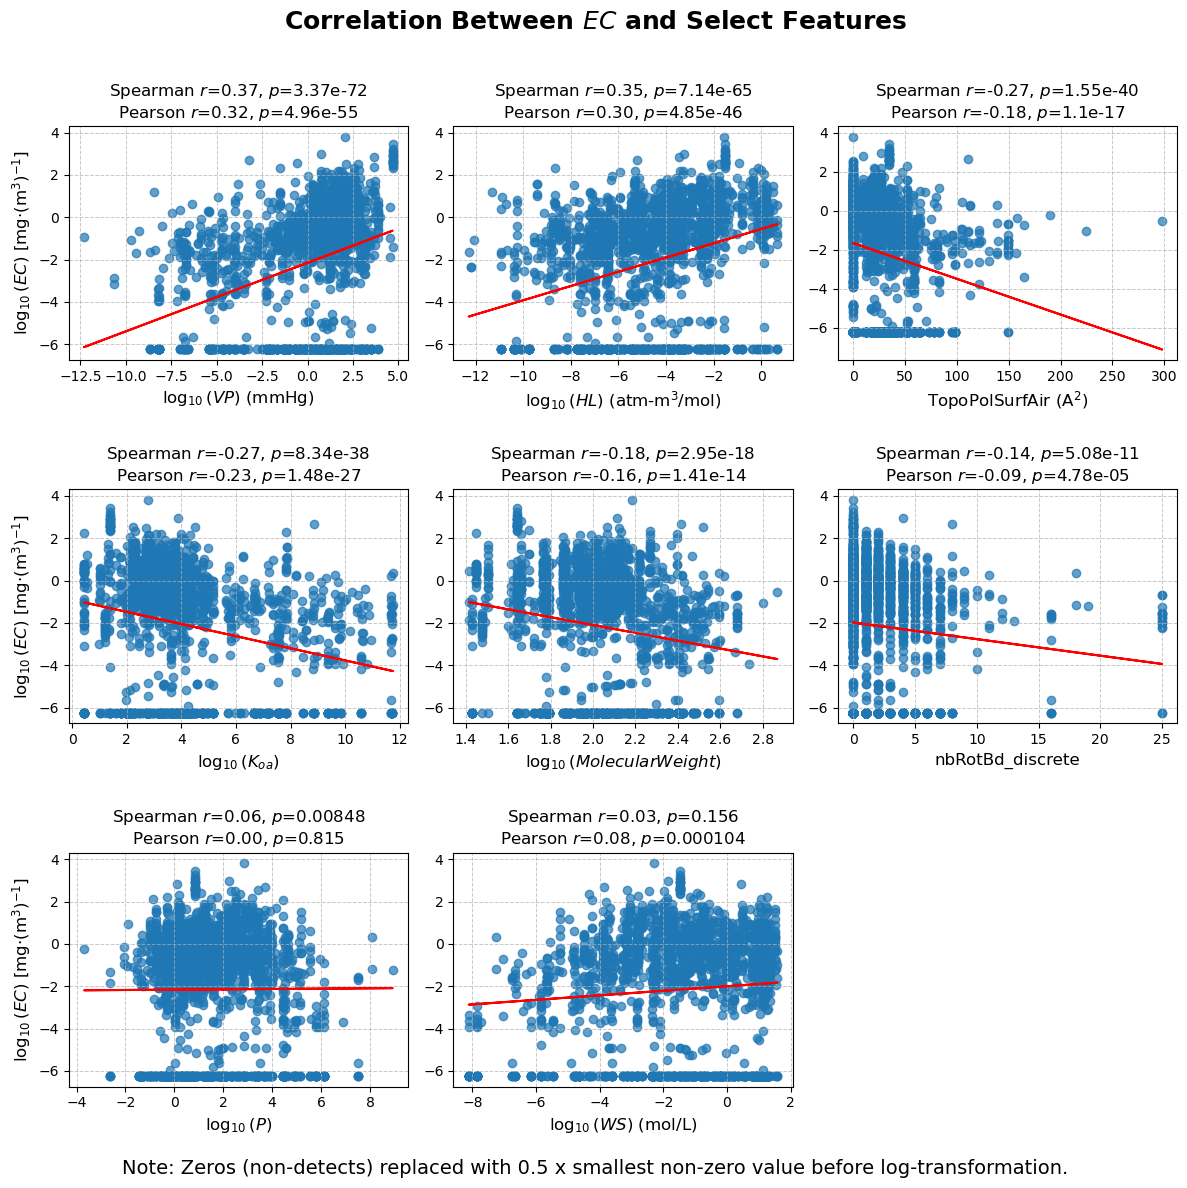

In [8]:
plot.correlation_by_feature(
    ec_for_naics['sector'],
    correlation_features.rename(label_for_feature, axis=1),
    suptitle='Correlation Between $\mathit{EC}$ and Select Features',
    write_path='figures/correlation_by_feature.png'
)

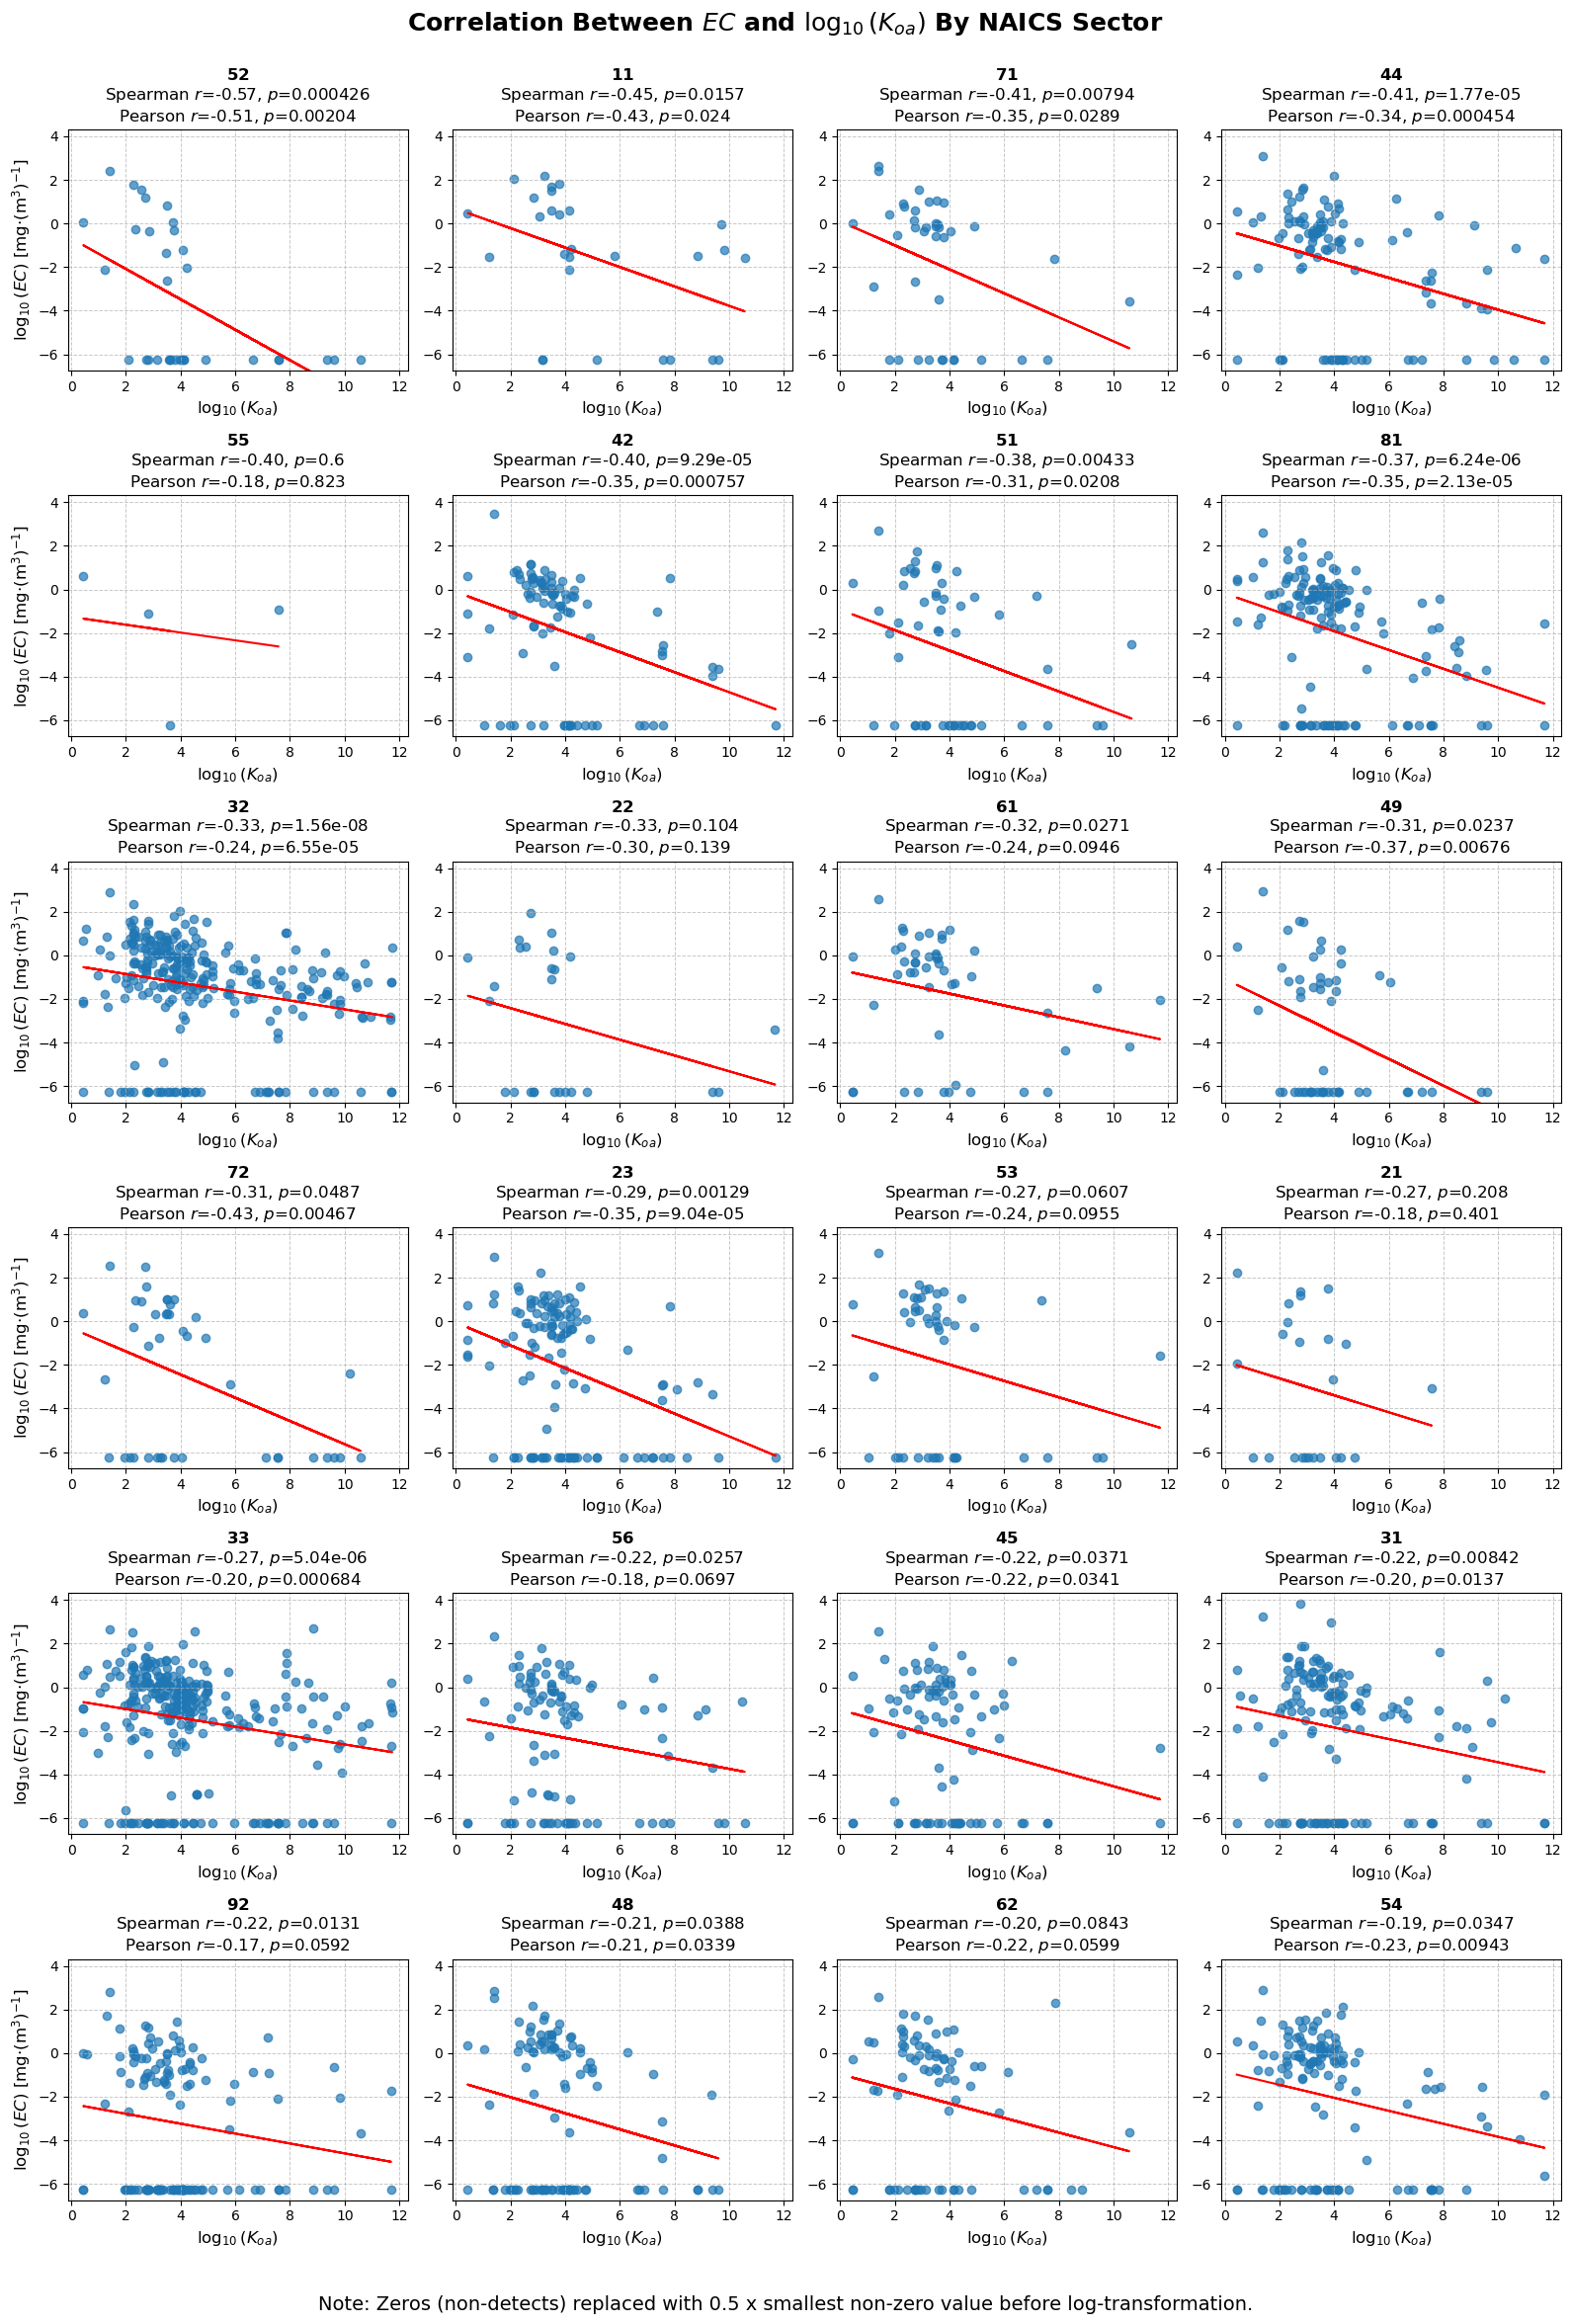

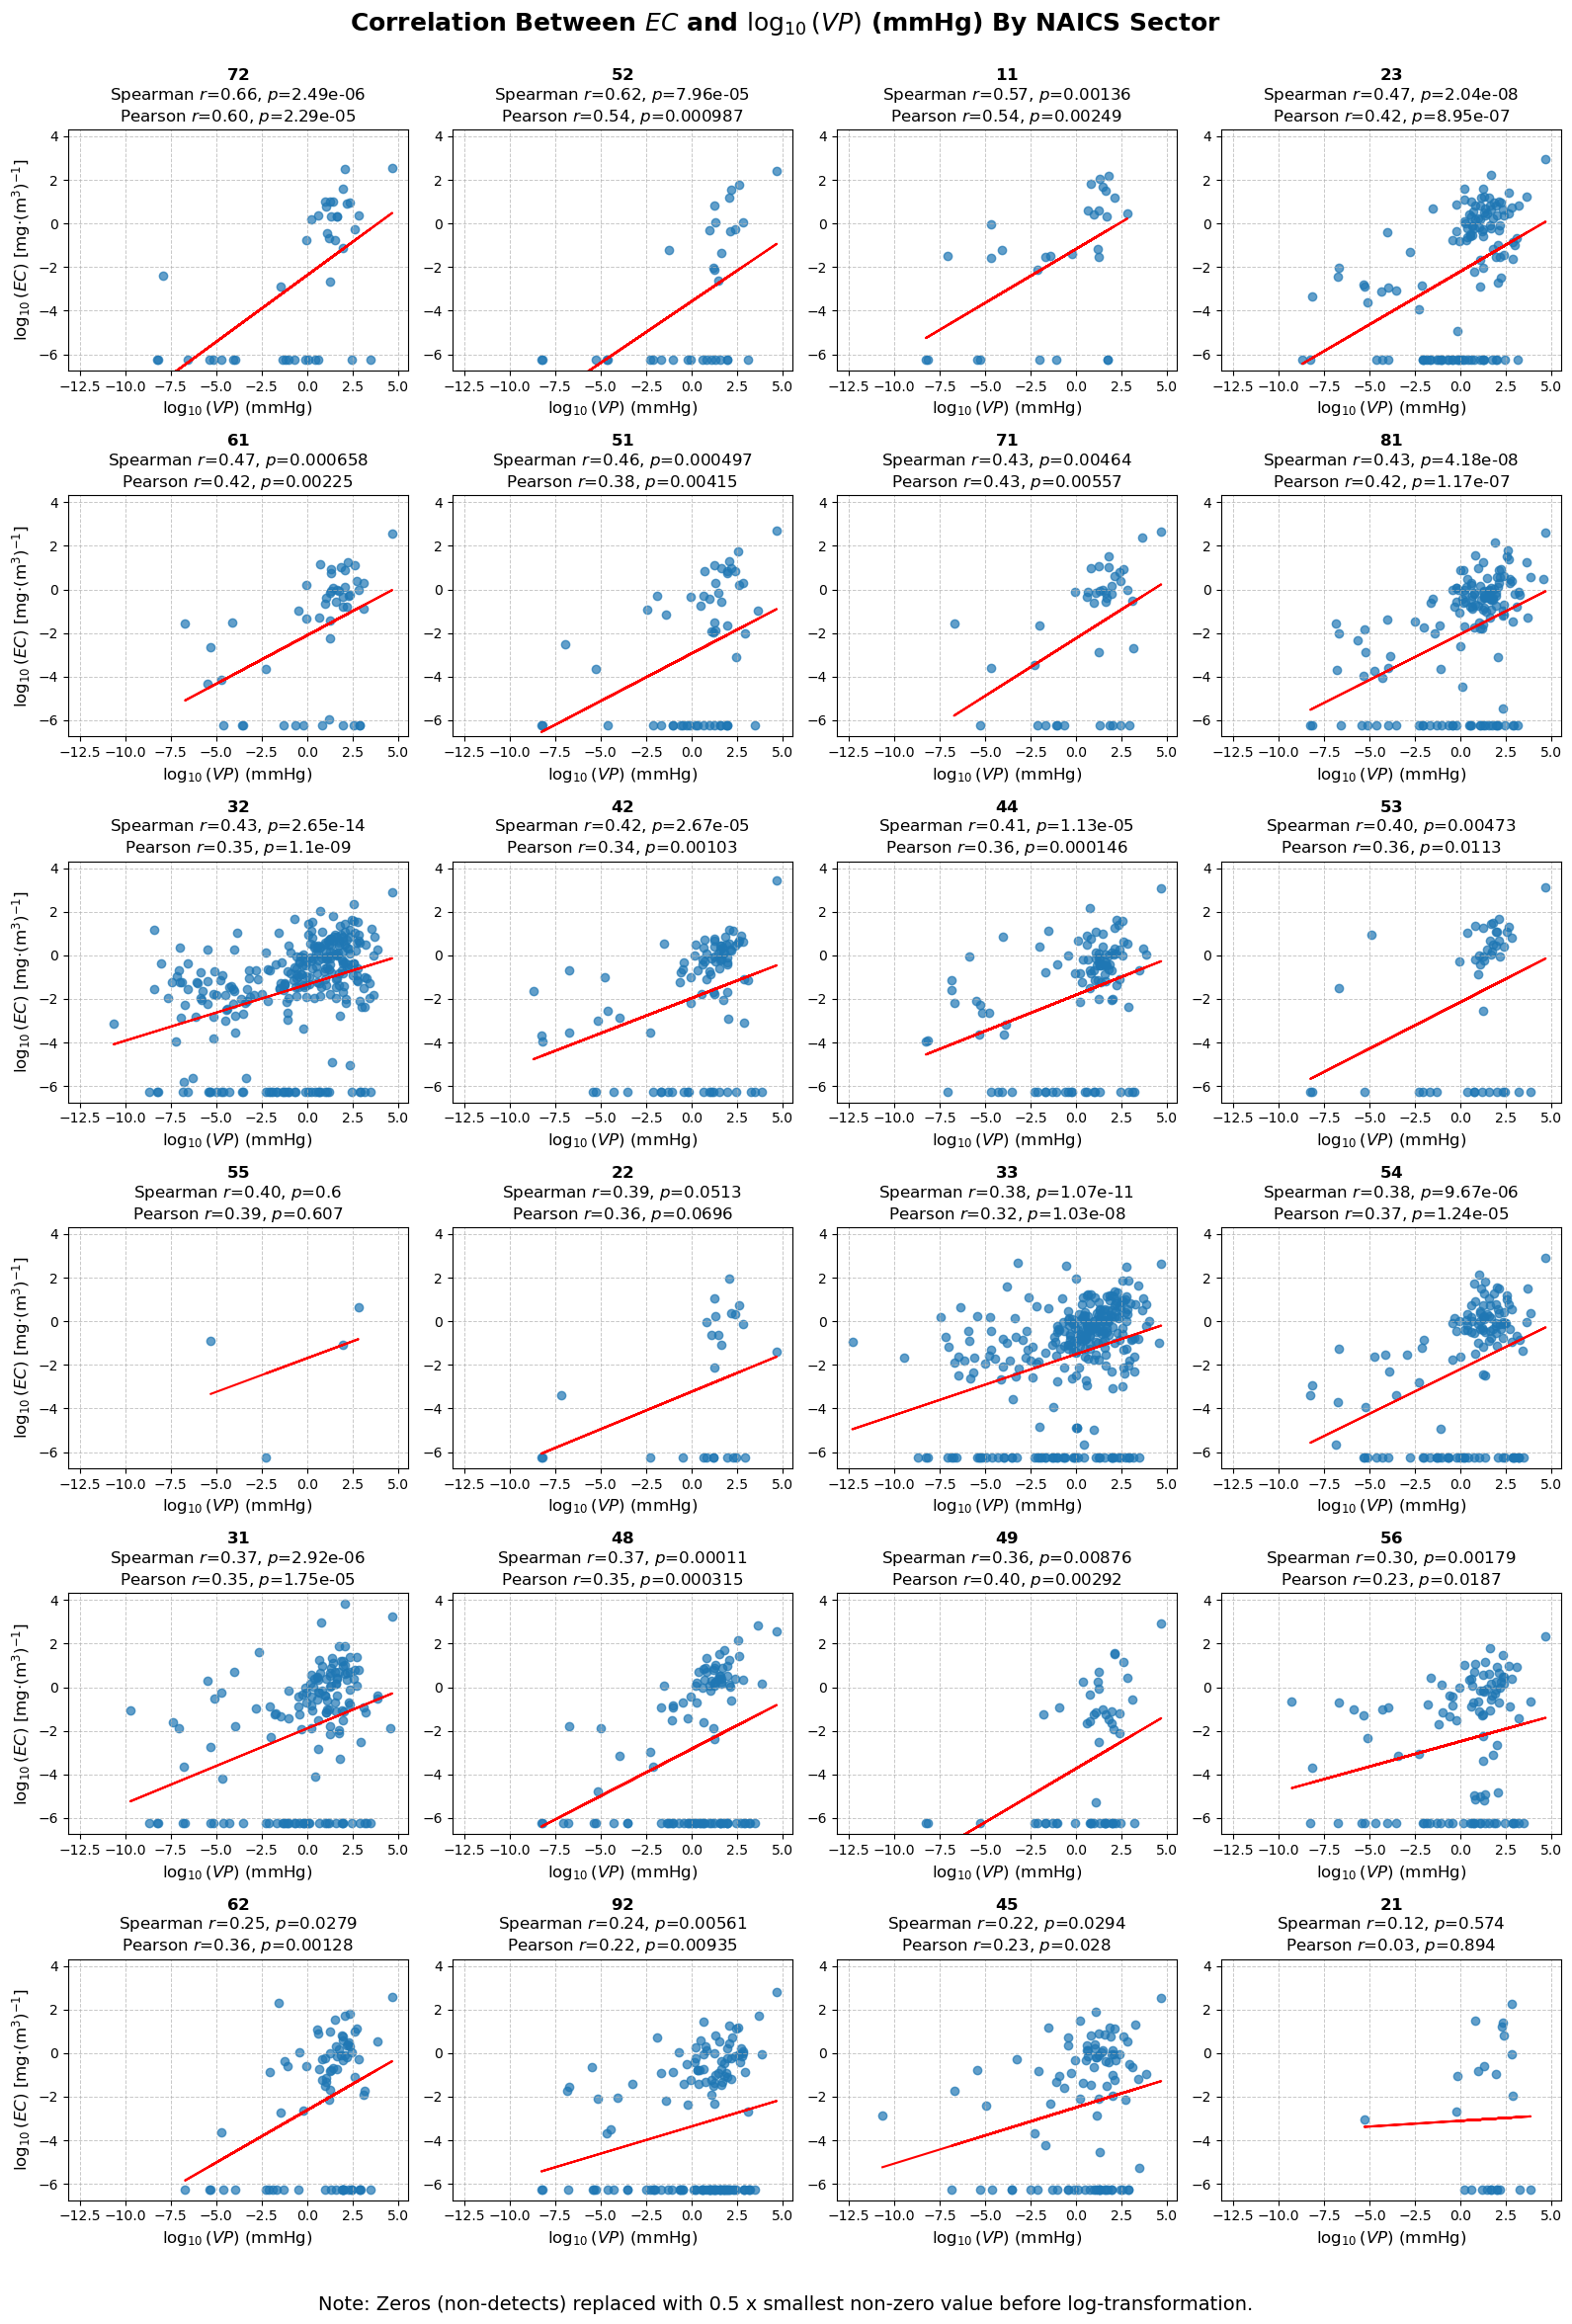

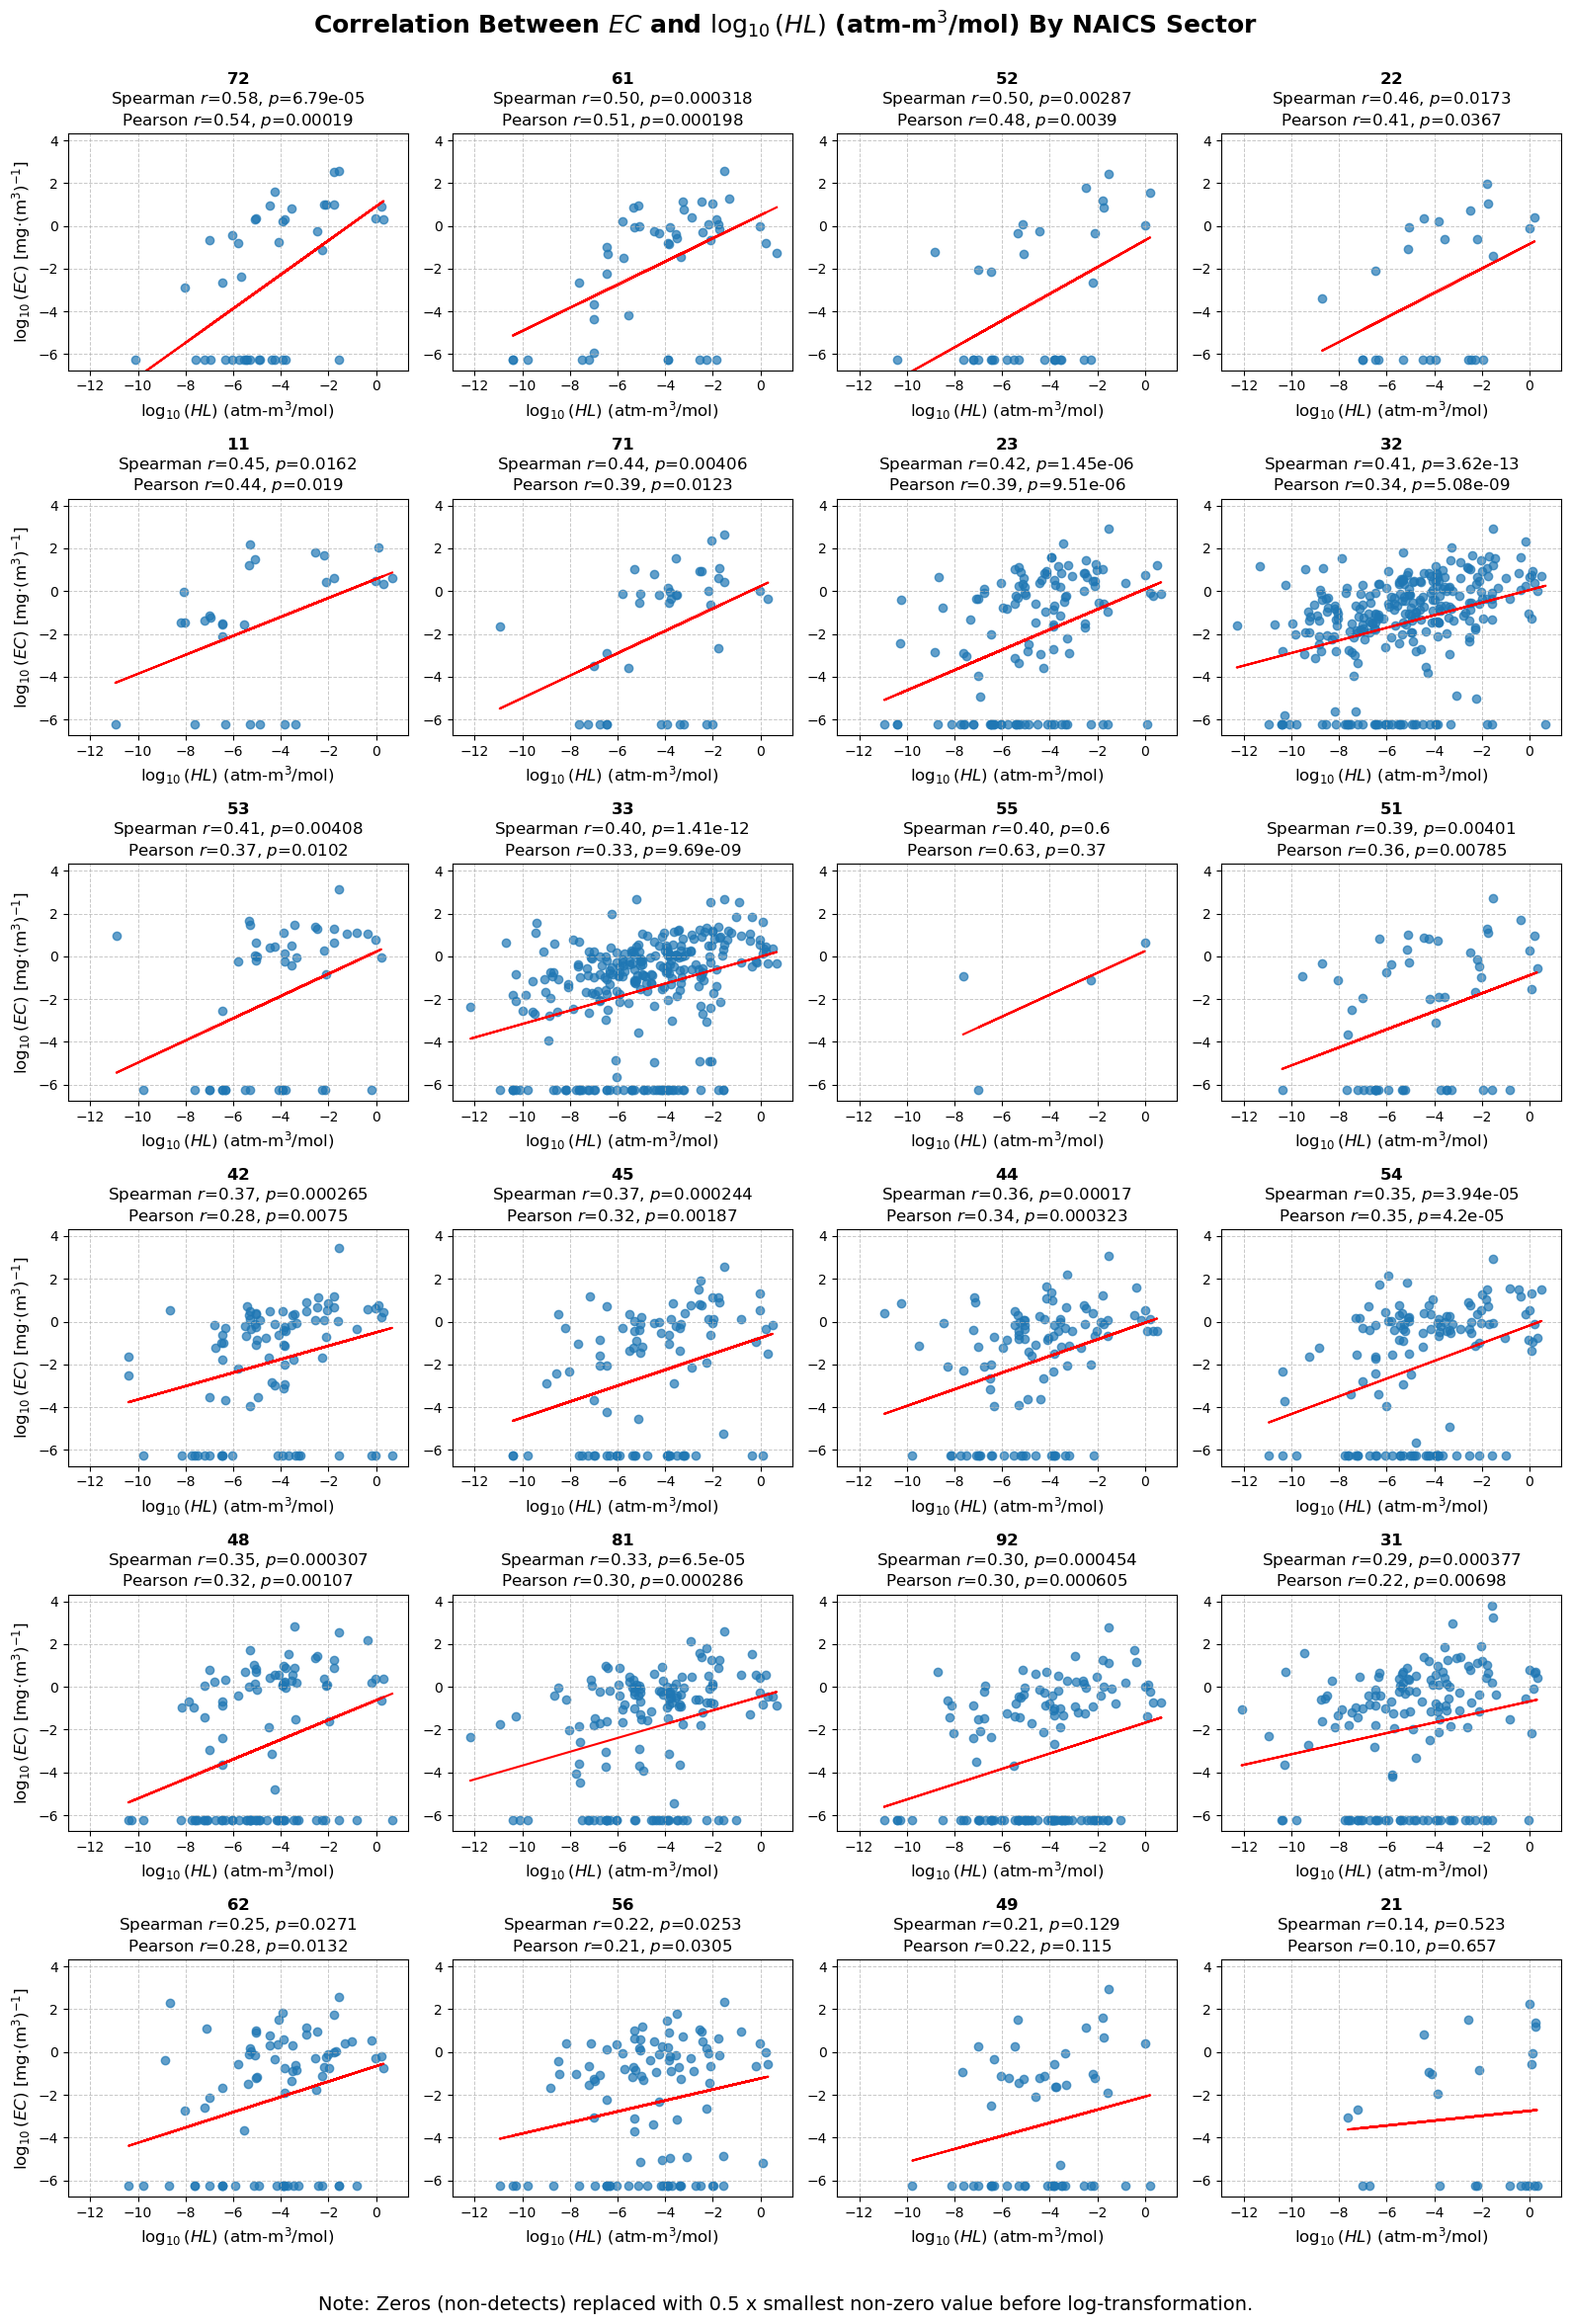

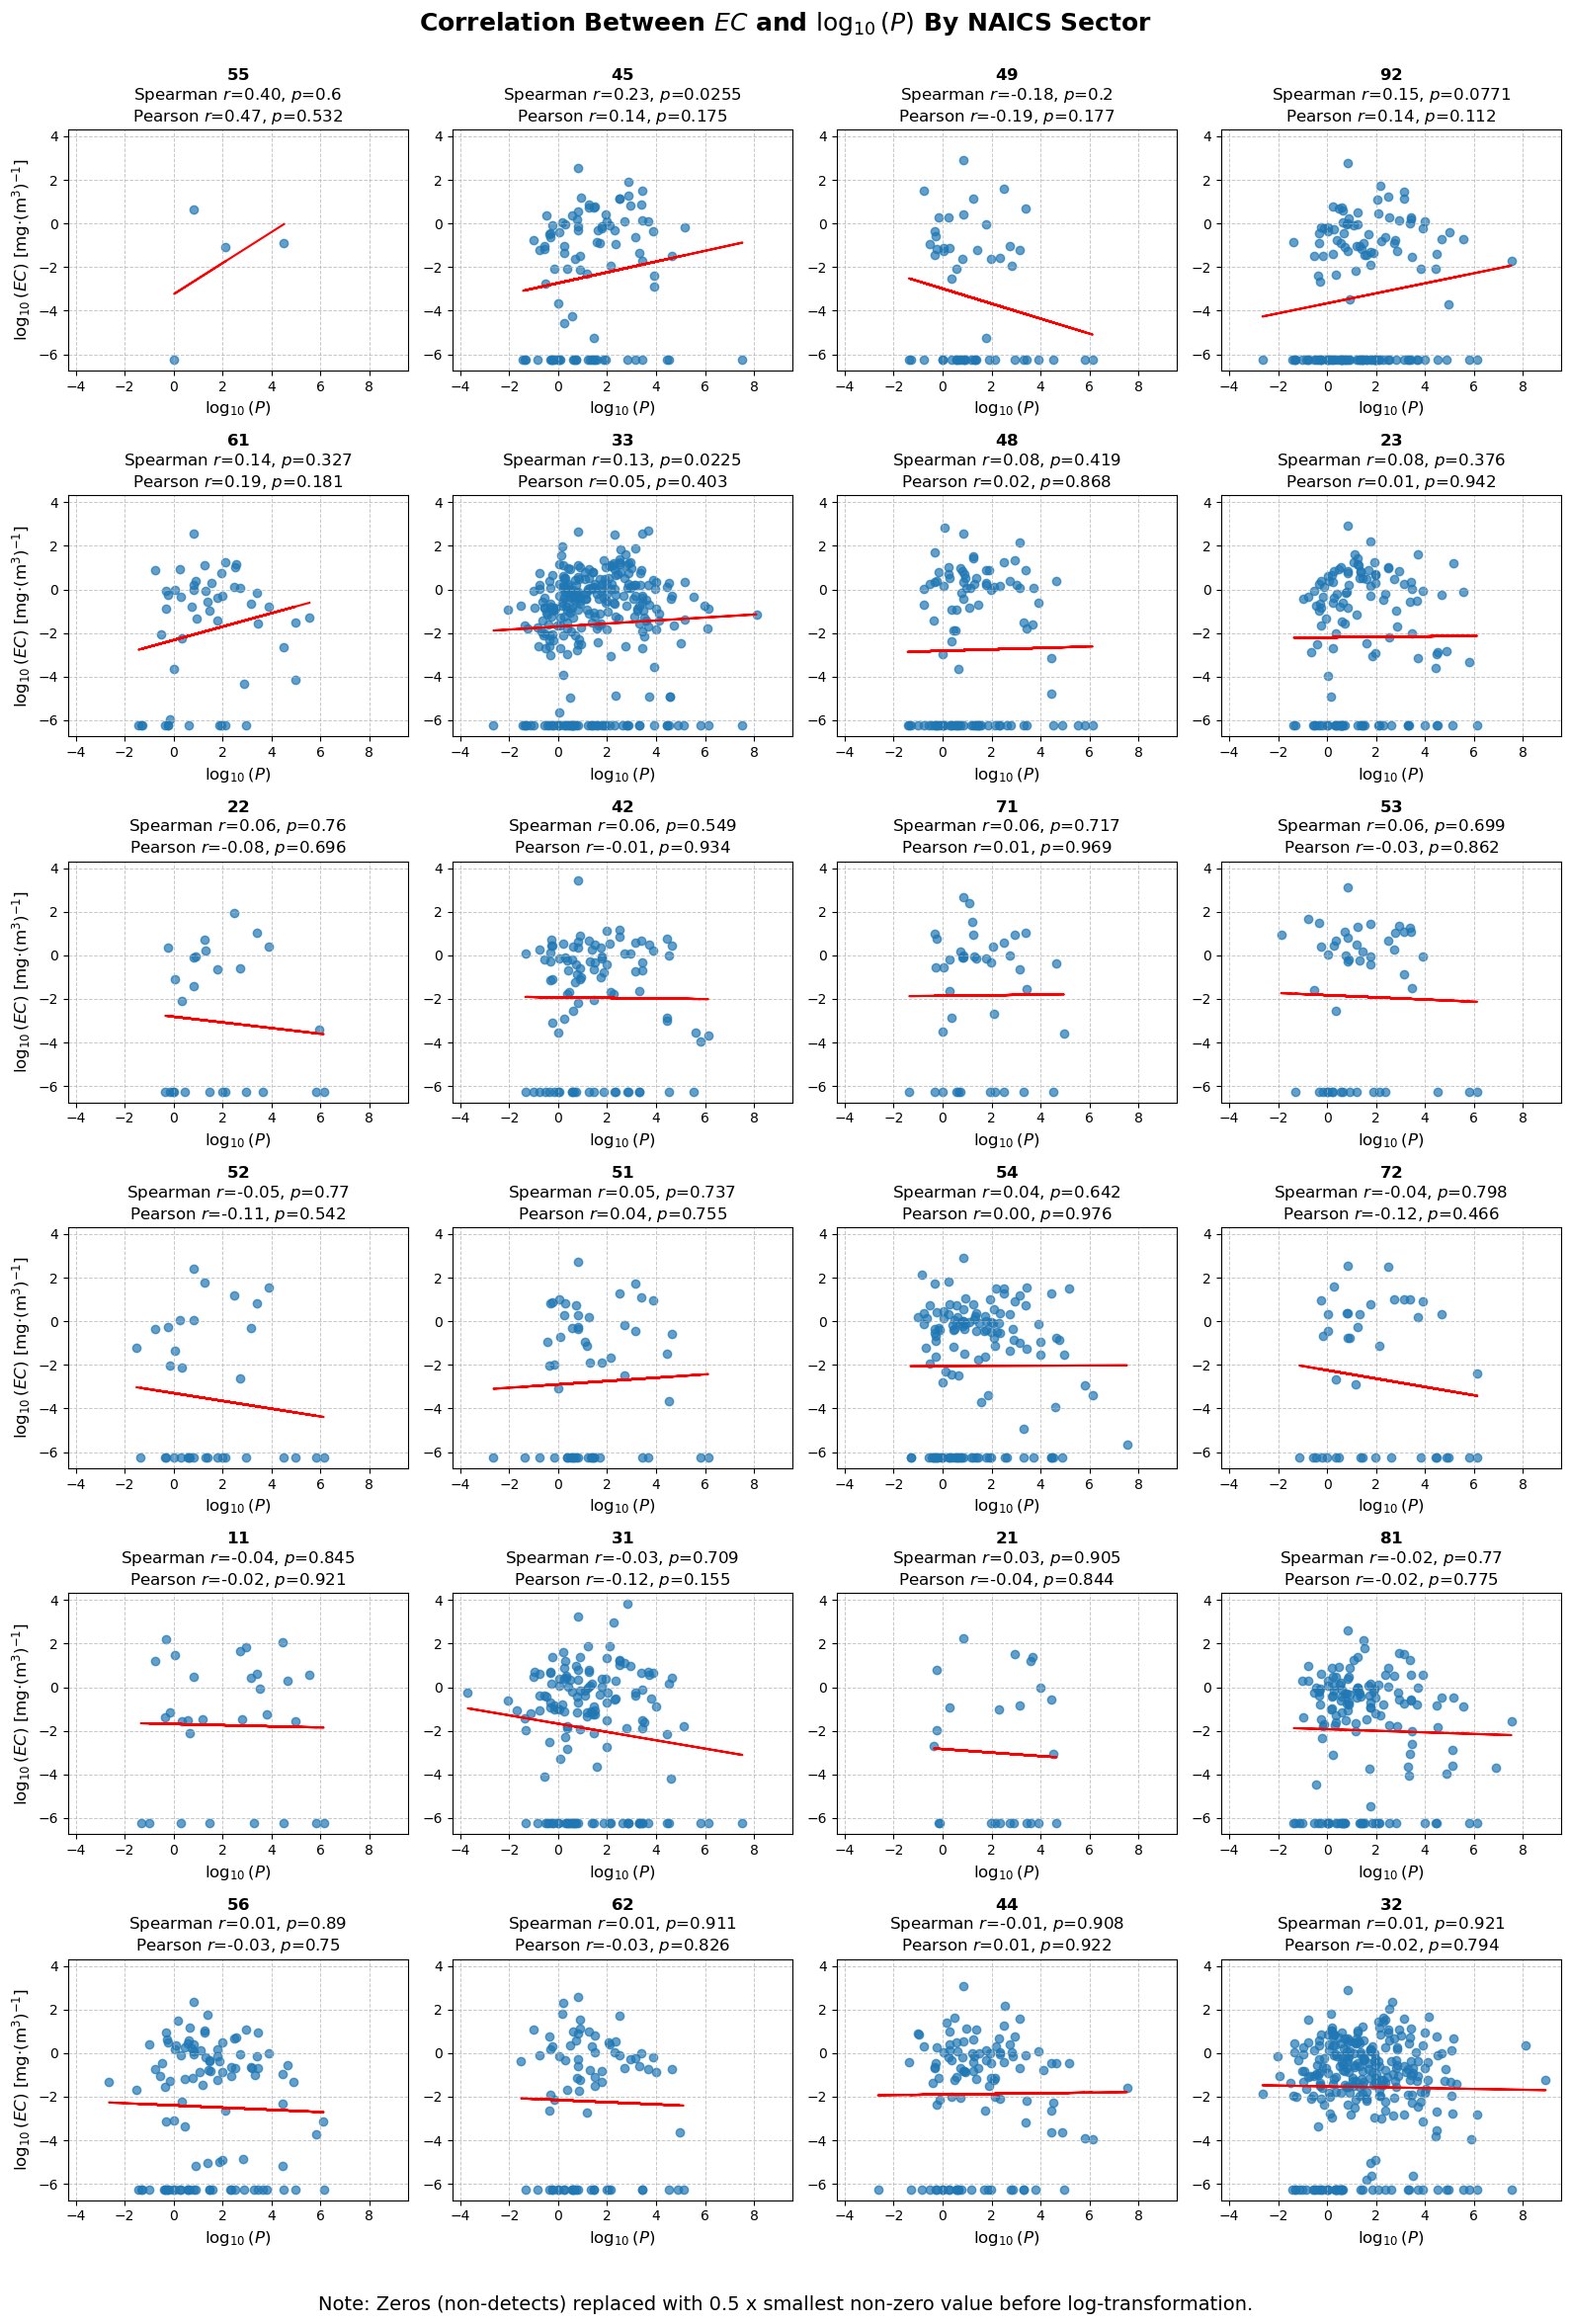

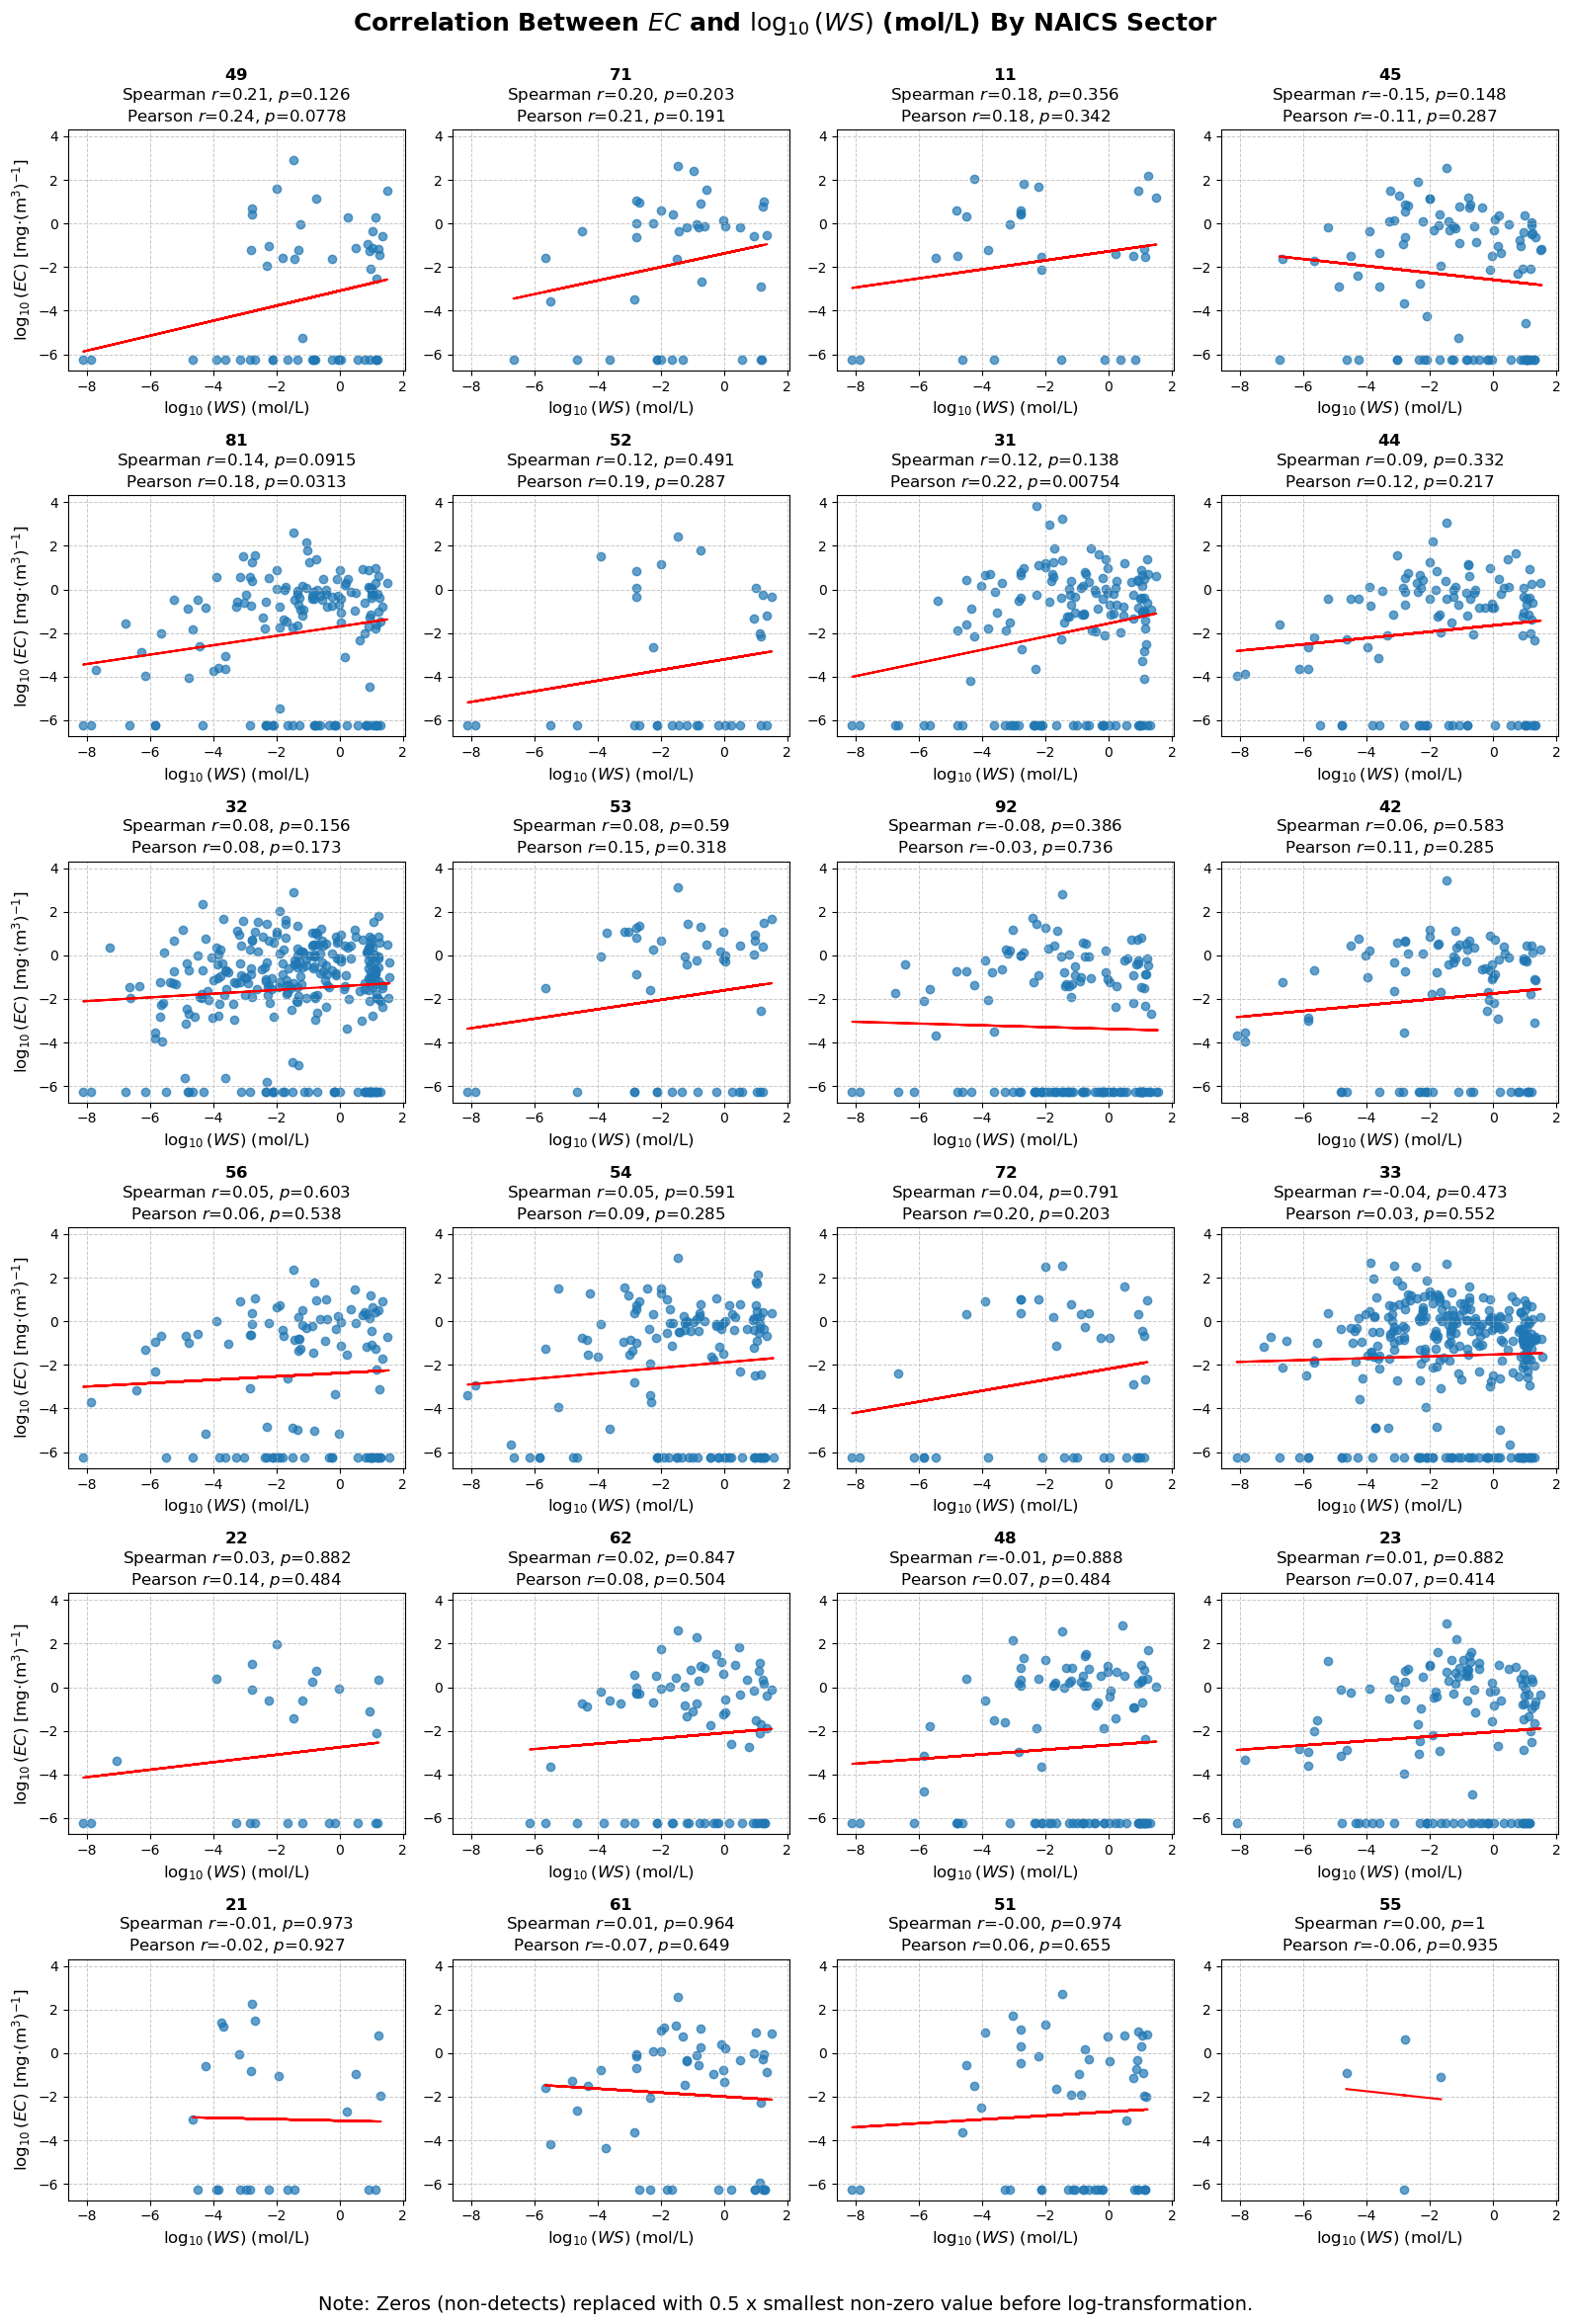

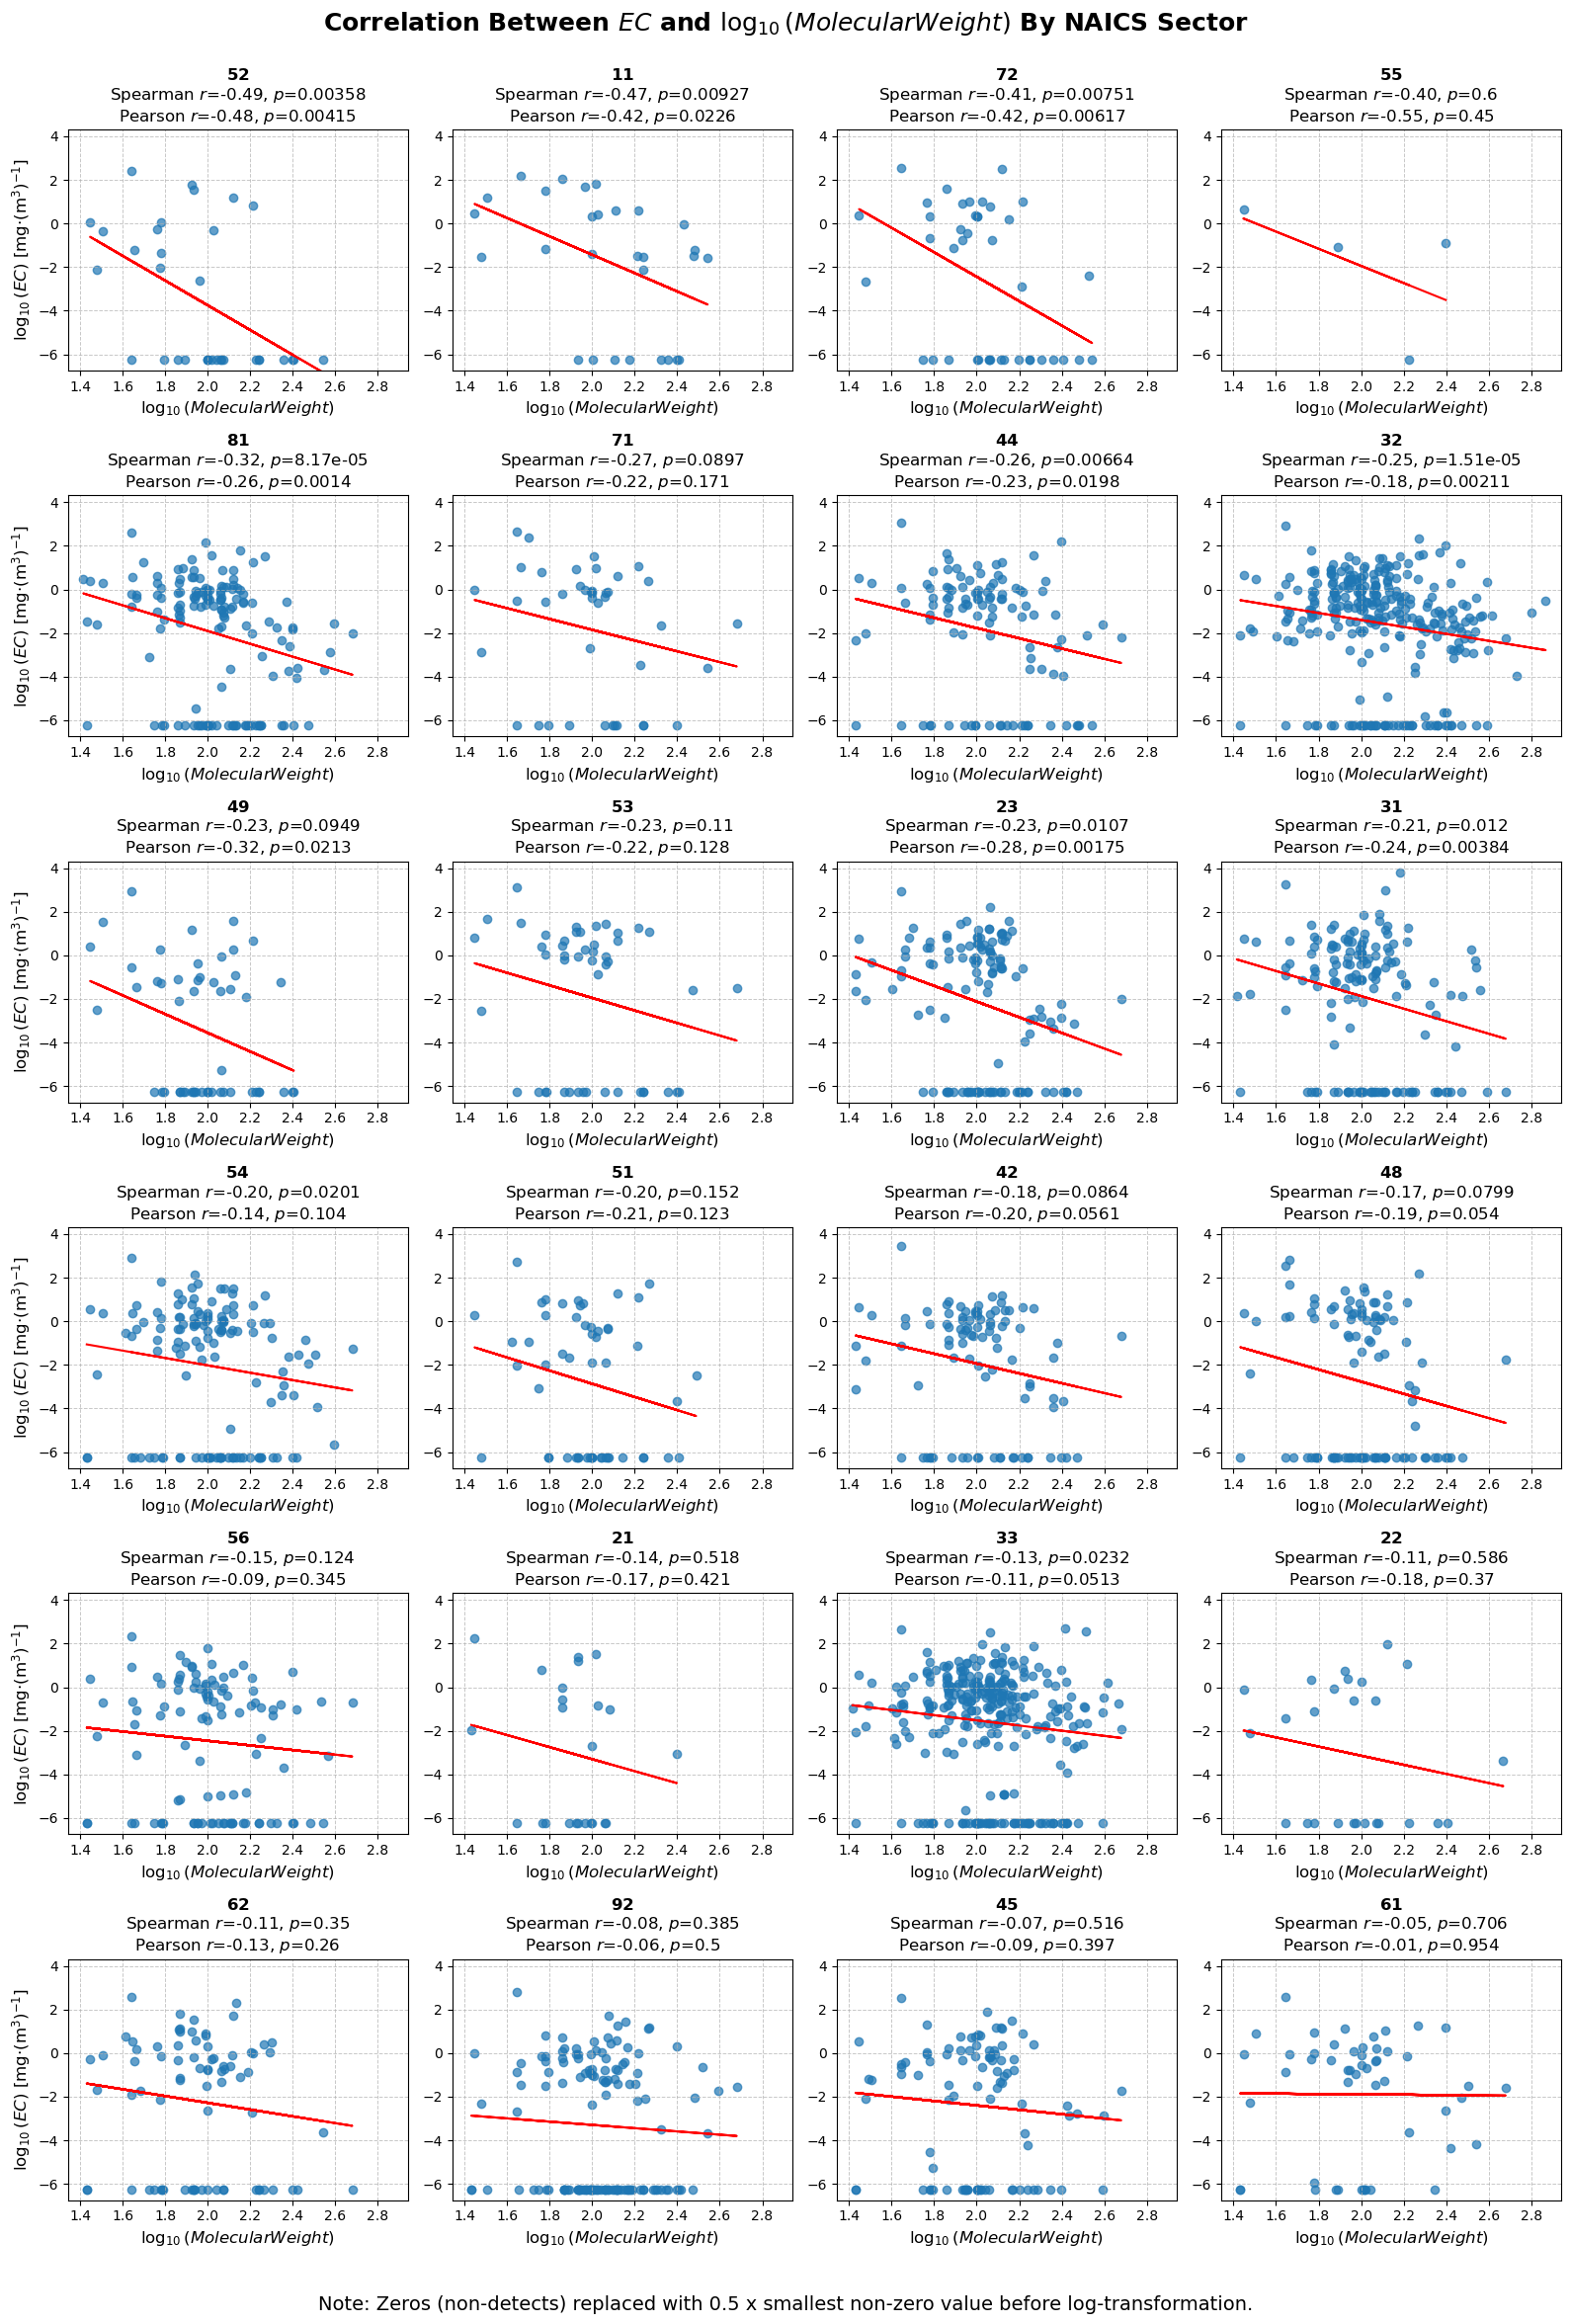

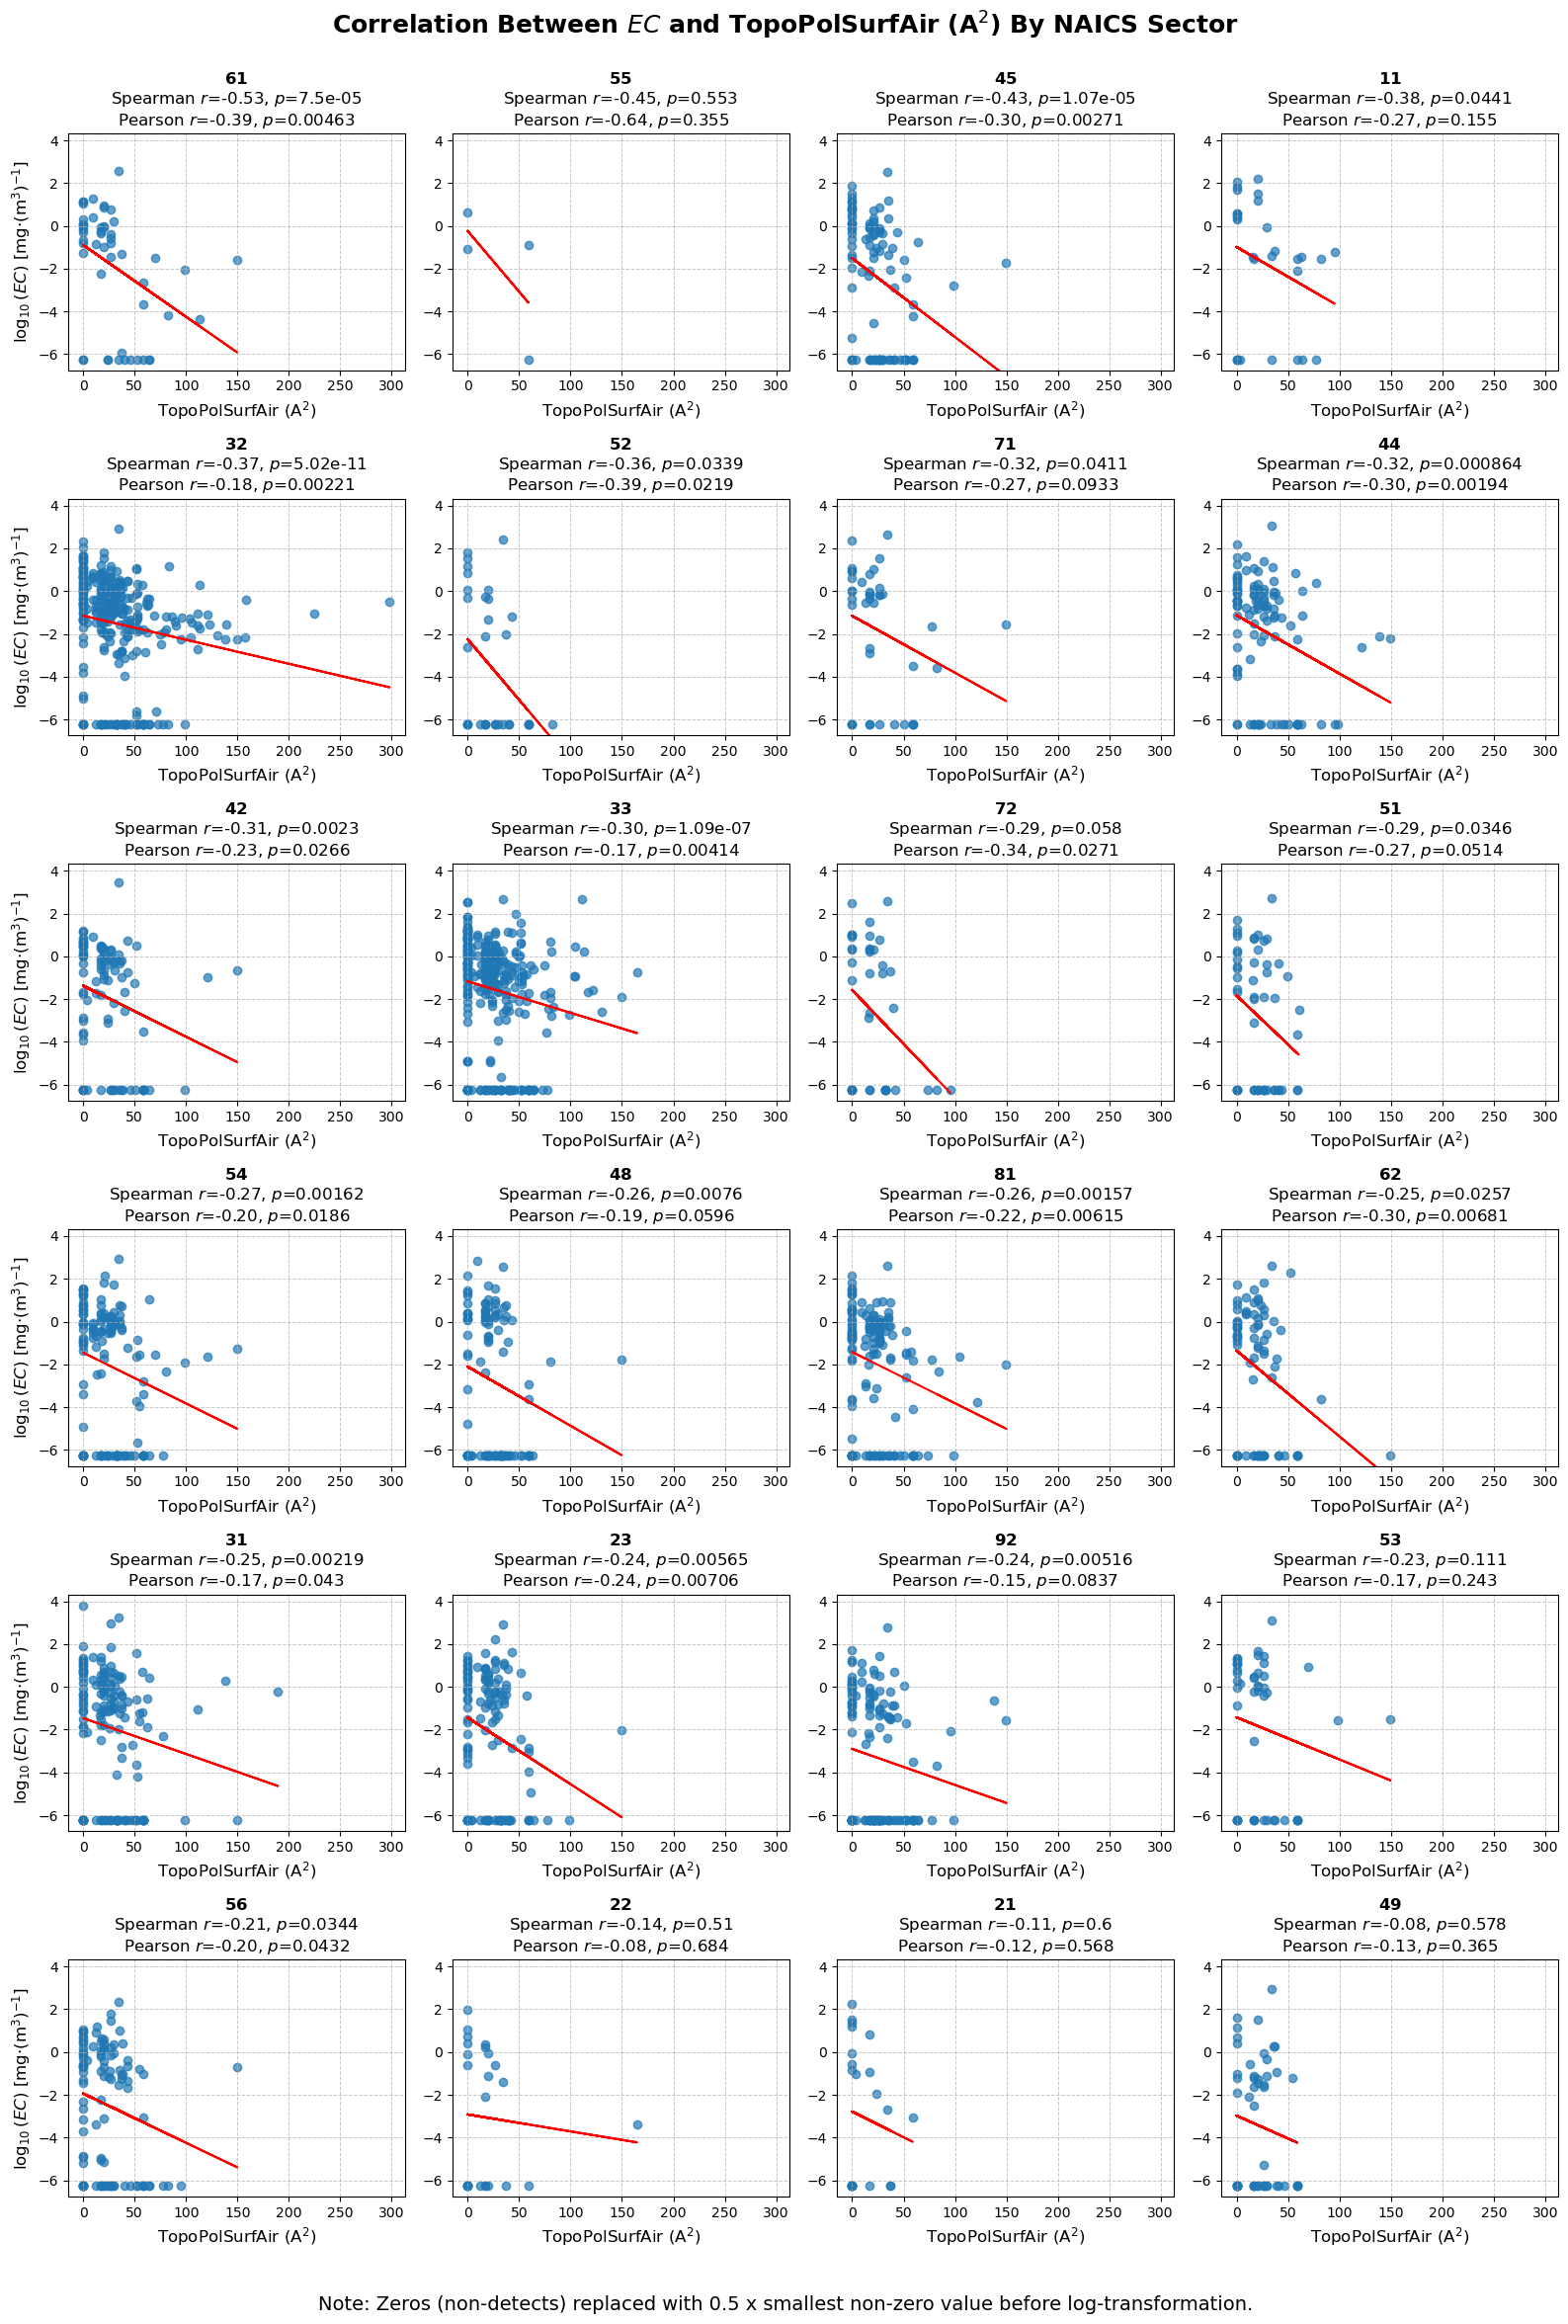

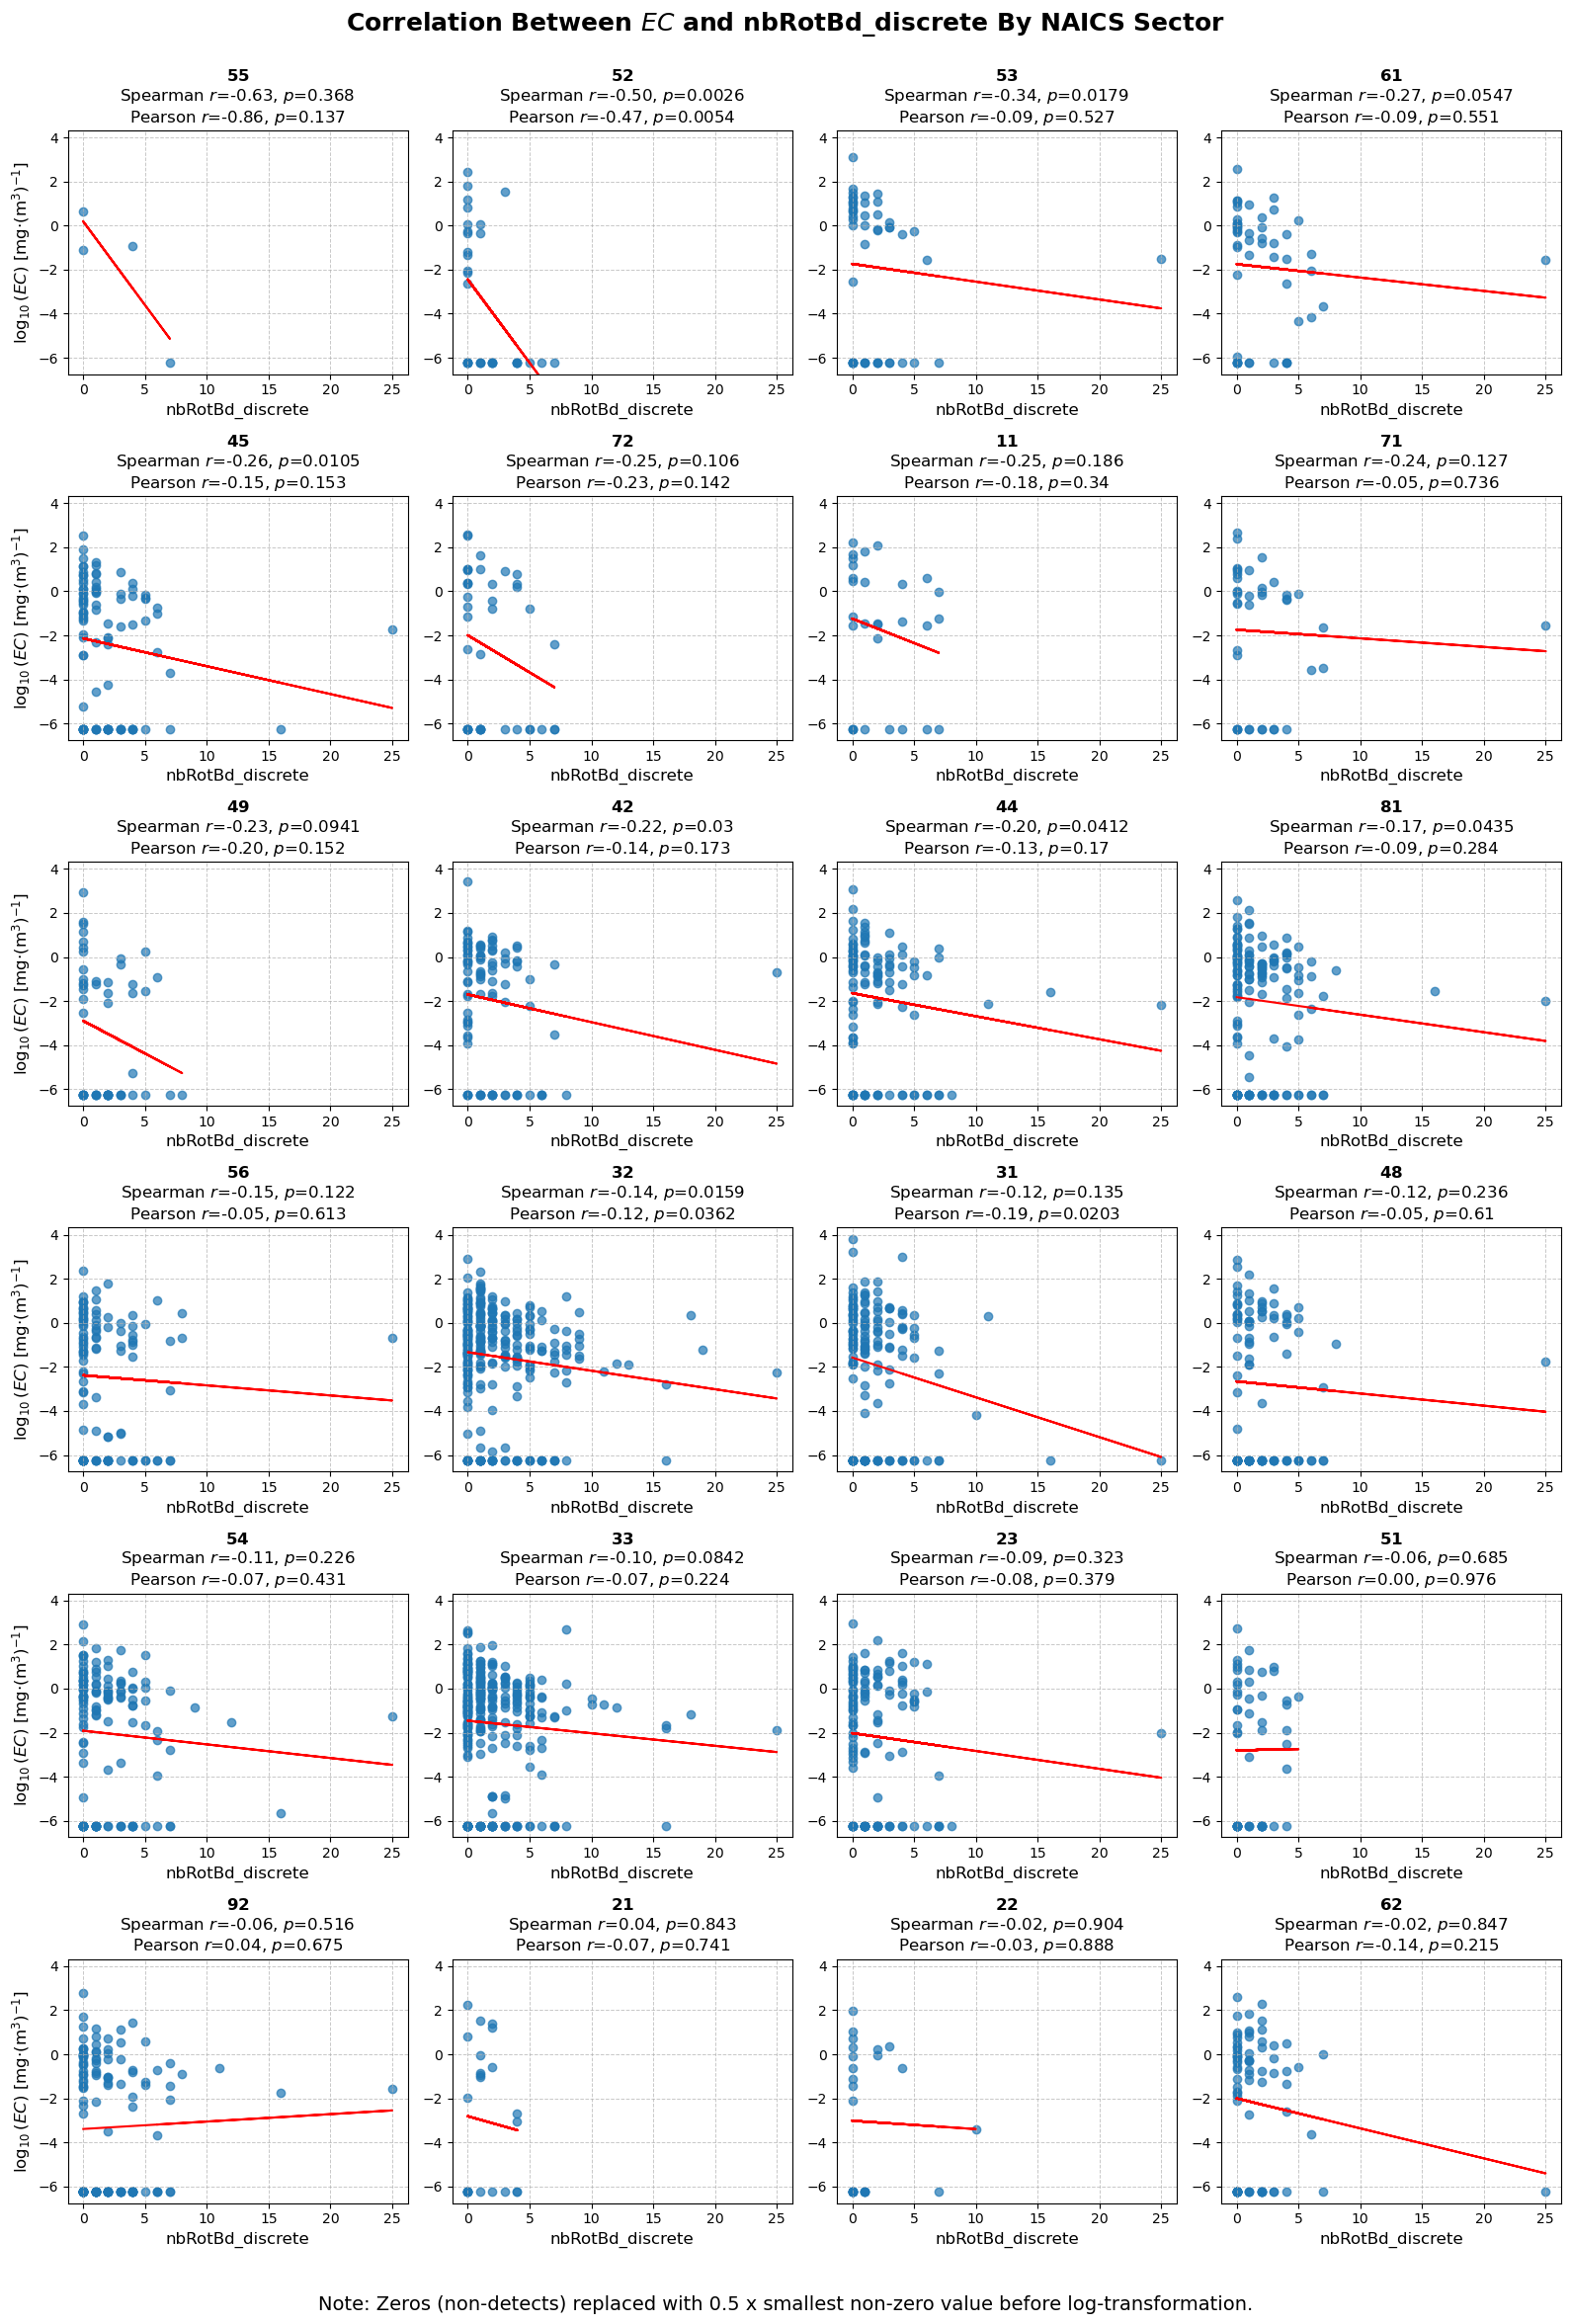

In [9]:
for feature, values in correlation_features.items():
    
    label = label_for_feature[feature]
    suptitle = f'Correlation Between $\\mathit{{EC}}$ and {label} By NAICS Sector'
    write_path = f'figures/correlation_{feature}_by_naics.png'
    
    plot.correlation_by_naics(
        ec_for_naics['sector'],
        values,
        xlabel=label,
        suptitle=suptitle,
        write_path=write_path
    )

## Model Development

In [10]:
def holdout_chemicals(y, holdout_fraction=0.1, random_state=42):
    """
    Reserve ~10% of chemicals as hold-out by DTXSID.
    Returns y_dev, y_val: the development set and hold-out set for the target.
    """
    unique_chemicals = y.index.get_level_values("DTXSID").unique()
    n_holdout = int(len(unique_chemicals) * holdout_fraction)
    
    rng = np.random.RandomState(random_state)
    shuffled_chemicals = rng.permutation(unique_chemicals)
    holdout_chem = shuffled_chemicals[:n_holdout]
    
    chem_values = y.index.get_level_values("DTXSID")
    y_dev = y.loc[~chem_values.isin(holdout_chem)]
    y_val = y.loc[chem_values.isin(holdout_chem)]
    
    return y_dev, y_val

In [11]:
property_columns = [    
    'VP_pred',
    'KOA_pred',
    'MolWeight',
    'TopoPolSurfAir'
]

y_full = ec_for_naics['sector'].copy()
X_full, y_full = (
    opera_features[property_columns]
    .align(y_full, join='inner', axis=0)
)

# Updated code section #
X_full['VP_pred'] = np.log10(X_full['VP_pred'])
X_full['KOA_pred'] = np.log10(X_full['KOA_pred'])
X_full['MolWeight'] = np.log10(X_full['MolWeight'])
#                      #

y_detect = y_full.loc[y_full>0.]
X_detect = X_full.loc[y_detect.index]

In [12]:
y_full_dev, y_full_val = holdout_chemicals(y_full)
y_full_dev = plot.preprocess_target(y_full_dev)

X_full_dev = X_full.loc[y_full_dev.index]
X_full_val = X_full.loc[y_full_val.index]

y_detect_dev, y_detect_val = holdout_chemicals(y_detect)
y_detect_dev = plot.preprocess_target(y_detect_dev)

X_detect_dev = X_detect.loc[y_detect_dev.index]
X_detect_val = X_detect.loc[y_detect_val.index]

1. Full Dataset: Physical-Chemical Properties Only
2. Full Dataset: Physical-Chemical Properties & NAICS
3. Detects Only: Physical-Chemical Properties Only
4. Detects Only: Physical-Chemical Properties & NAICS

### Build scikit-learn Models

In [13]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_ignore_naics = ColumnTransformer([
    ('num', numeric_pipeline, property_columns)
])

regressor = LinearRegression()

model_ignore_naics = Pipeline([
    ('preprocessor', preprocessor_ignore_naics),
    ('regressor', regressor)
])

In [14]:
naics_col = ['naics_id']

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor_with_naics = ColumnTransformer([
    ('num', numeric_pipeline, property_columns),
    ('cat', cat_pipeline, naics_col)
])

model_with_naics = Pipeline([
    ('preprocessor', preprocessor_with_naics),
    ('regressor', regressor)
])

In [15]:
def score_metrics(y_true, y_pred):
    """
    Returns a dict with R2, RMSE, MedAE for quick printing.
    """
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MedAE': median_absolute_error(y_true, y_pred)
    }

In [16]:
def cross_validate_sklearn(model, X, y, n_splits=5):
    """
    Performs 5-fold GroupKFold (by DTXSID) on (X,y),
    Returns a list of score dicts (R2, RMSE, MedAE).
    """
    scores = []
    groups = y.index.get_level_values("DTXSID")
    gkf = GroupKFold(n_splits=n_splits)
    
    # Convert to a list so we can reuse the exact same folds
    folds = list(gkf.split(X, y, groups=groups))
    
    for train_idx, test_idx in folds:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        fold_score = score_metrics(y_test, y_pred)
        scores.append(fold_score)
    
    return scores, folds

In [17]:
mean_scores = {}

In [18]:
# cross_validate_sklearn on "ignore NAICS"
scores_ignore_naics, folds_ignore = cross_validate_sklearn(
    model_ignore_naics, 
    X_full_dev,  
    y_full_dev    
)

mean_scores['OLS, All Data'] = pd.DataFrame(scores_ignore_naics).mean()

In [19]:
# cross_validate_sklearn on "with NAICS"
X_full_dev_with_naics = X_full_dev.reset_index(level="naics_id")
scores_with_naics, folds_with = cross_validate_sklearn(
    model_with_naics,
    X_full_dev_with_naics,
    y_full_dev
)

In [20]:
# cross_validate_sklearn on "ignore NAICS"
scores_ignore_naics, folds_ignore = cross_validate_sklearn(
    model_ignore_naics, 
    X_detect_dev,  
    y_detect_dev    
)

mean_scores['OLS, Detects Only'] = pd.DataFrame(scores_ignore_naics).mean()

In [21]:
# cross_validate_sklearn on "with NAICS"
X_detect_dev_with_naics = X_detect_dev.reset_index(level="naics_id")
scores_with_naics, folds_with = cross_validate_sklearn(
    model_with_naics,
    X_detect_dev_with_naics,
    y_detect_dev
)

## Next Steps
- Try a random intercept model
- Try features from CDR, e.g., production volume

### CV FOR RANDOM-INTERCEPT (statsmodels)

In [22]:
# FIXME: Set an integer random state for the CV splitter for comparability?
# TODO: Shared logic with cv_sklearn can be moved to helper function
def cross_validate_mixed_effects(
    X, y, 
    numeric_columns=None, 
    n_splits=5, 
    use_naics=True
):
    """
    Performs 5-fold GroupKFold on (X, y) with grouping by y.index.get_level_values('DTXSID')
    (or whichever grouping you're using for new-chemical analysis).
    
    For each fold:
      - Splits into train/test
      - Calls fit_random_intercept_model
      - Returns fold metrics
    
    Returns (scores_list, folds_used)
    """
    # If we want NAICS, we reset index level to get 'naics_id' as a column
    if use_naics:
        X = X.reset_index(level="naics_id")
        
    scores = []
    iccs = [] # Intraclass Correlation Coefficients
    mdfs = []
    
    # We'll group by the chemical ID
    groups = y.index.get_level_values("DTXSID")
    gkf = GroupKFold(n_splits=n_splits)
    folds = list(gkf.split(X, y, groups=groups))
    
    for train_idx, test_idx in folds:
        # Slice train/test
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit / predict with mixed model
        y_pred, icc, mdf = fit_random_intercept_model(
            X_train, y_train, 
            X_test, y_test, 
            numeric_columns=numeric_columns, 
            use_naics=use_naics
        )
        
        # Score
        fold_score = score_metrics(y_test, y_pred)
        scores.append(fold_score)
        iccs.append(icc)
        mdfs.append(mdf)
    
    return scores, iccs, mdfs

def intraclass_correlation(var_group, var_resid):
    '''
    Computes Intraclass Correlation Coefficient (ICC).
    
    Parameters
    ----------
    var_group :
        Random intercept variance (mdf.cov_re.iloc[0,0]).
    var_resid : 
        Residual variance (mdf.scale).
    '''
    return var_group / (var_group + var_resid)

In [23]:
def fit_random_intercept_model(
    X_train, y_train, 
    X_test, y_test, 
    numeric_columns=None, 
    use_naics=True
):
    """
    Fits a random-intercept model (statsmodels MixedLM) on (X_train, y_train),
    optionally with numeric columns (impute + scale).
    
    If numeric_columns is None or empty, we do a no-covariates model (y ~ 1).
    If use_naics=True and 'naics_id' in X_train, we group by naics_id.
    Otherwise, a single dummy group => effectively OLS.
    
    Returns:
        y_pred_test : predictions on X_test
        icc         : intraclass correlation for the random intercept
    """
    # 1) If we have numeric columns, do median-impute + scale
    if numeric_columns and len(numeric_columns) > 0:
        numeric_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])
        
        X_train_num = X_train[numeric_columns].copy()
        X_test_num  = X_test[numeric_columns].copy()
        
        numeric_pipeline.fit(X_train_num)
        X_train_num_t = numeric_pipeline.transform(X_train_num)
        X_test_num_t  = numeric_pipeline.transform(X_test_num)
        
        num_col_names = [f"num_{i}" for i in range(X_train_num_t.shape[1])]
        
        df_train_sm = pd.DataFrame(X_train_num_t, 
                                   columns=num_col_names,
                                   index=X_train.index)
        df_test_sm  = pd.DataFrame(X_test_num_t,
                                   columns=num_col_names,
                                   index=X_test.index)
    else:
        # No numeric columns => no transformations
        num_col_names = []
        df_train_sm = pd.DataFrame(index=X_train.index)
        df_test_sm  = pd.DataFrame(index=X_test.index)
    
    # 2) Add target
    df_train_sm["y"] = y_train.to_numpy()
    df_test_sm["y"]  = y_test.to_numpy()
    
    # 3) Optionally attach NAICS as grouping factor
    if use_naics and ("naics_id" in X_train.columns):
        df_train_sm["naics_id"] = X_train["naics_id"].to_numpy()
        df_test_sm["naics_id"]  = X_test["naics_id"].to_numpy()
    
    # 4) Build formula
    # If we have numeric columns, build "y ~ 1 + num_0 + num_1 + ..."
    # Otherwise just "y ~ 1"
    if len(num_col_names) > 0:
        formula_terms = " + ".join(num_col_names)
        formula = f"y ~ 1 + {formula_terms}"
    else:
        formula = "y ~ 1"
    
    # 5) Grouping factor
    if use_naics and ("naics_id" in df_train_sm.columns):
        groups = df_train_sm["naics_id"]
    else:
        # single group => effectively OLS
        df_train_sm["dummy_group"] = 0
        groups = df_train_sm["dummy_group"]
    
    # 6) Fit the mixed model
    model = smf.mixedlm(
        formula=formula,
        data=df_train_sm,
        groups=groups,
        re_formula="1"
    )
    mdf = model.fit(method="bfgs", reml=False, maxiter=200)
    
    # 7) Predictions & ICC
    y_pred_test = mdf.predict(df_test_sm)

    var_group = mdf.cov_re.iloc[0,0] if mdf.cov_re.shape[0] > 0 else 0.0
    var_resid = mdf.scale
    icc = intraclass_correlation(var_group, var_resid)

    # FIXME: Maybe you don't need to handle y_pred_test here, return only the model object
    return y_pred_test, icc, mdf

### Cross-Validation Comparison

In [24]:
scores_me, iccs, mdfs = cross_validate_mixed_effects(
    X_detect_dev, 
    y_detect_dev, 
    numeric_columns=property_columns,
    n_splits=5,
    use_naics=False
)

scores_me

C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 6.505792
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packag

[{'R2': 0.10574134390603329,
  'RMSE': 1.278885970923941,
  'MedAE': 0.7523270017298778},
 {'R2': 0.13989878321693483,
  'RMSE': 1.2792966664543575,
  'MedAE': 0.7145601479457357},
 {'R2': 0.3128896327441696,
  'RMSE': 1.333217853482236,
  'MedAE': 0.774341778085992},
 {'R2': 0.0982686384340209,
  'RMSE': 1.2713773286773498,
  'MedAE': 0.607806389862416},
 {'R2': 0.18413687712549653,
  'RMSE': 1.2068610519516159,
  'MedAE': 0.8064649421711664}]

In [25]:
iccs

[0.02145902980567041,
 0.02145902980567041,
 0.021660300828310164,
 0.021660300828310164,
 0.021660300828310164]

In [26]:
scores_me, iccs, mdfs = cross_validate_mixed_effects(
    X_detect_dev, 
    y_detect_dev, 
    numeric_columns=None,
    n_splits=5,
    use_naics=True
)

scores_me

C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 21.783336
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packa

[{'R2': -0.01032919311745184,
  'RMSE': 1.359351272052497,
  'MedAE': 0.8573375537826048},
 {'R2': -0.14111266290410995,
  'RMSE': 1.4735359965671755,
  'MedAE': 0.8439456006953341},
 {'R2': -0.01827990261946355,
  'RMSE': 1.6230109739422387,
  'MedAE': 0.9052899886730882},
 {'R2': -4.152743720231555e-06,
  'RMSE': 1.3388649653630476,
  'MedAE': 0.6966654383653742},
 {'R2': -0.014248641016471275,
  'RMSE': 1.3456150548925836,
  'MedAE': 0.8726792098246886}]

In [27]:
iccs

[0.5, 0.5, 0.026623789841195504, 0.022544647054157173, 0.021850856367554707]

In [28]:
scores_me, iccs, mdfs = cross_validate_mixed_effects(
    X_detect_dev, 
    y_detect_dev, 
    numeric_columns=property_columns,
    n_splits=5,
    use_naics=True
)

scores_me

C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 21.891048
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packa

[{'R2': 0.1098879320604158,
  'RMSE': 1.27591749247449,
  'MedAE': 0.7383691801244394},
 {'R2': 0.120711693074112,
  'RMSE': 1.2934872020127404,
  'MedAE': 0.7220171714811079},
 {'R2': 0.30933832003127326,
  'RMSE': 1.3366587646778634,
  'MedAE': 0.7758083953232159},
 {'R2': 0.09807963596800617,
  'RMSE': 1.2715105617390838,
  'MedAE': 0.6084525091584398},
 {'R2': 0.1878629127877609,
  'RMSE': 1.2041020393399664,
  'MedAE': 0.8065327605720954}]

In [29]:
mean_scores['Random Intercept'] = pd.DataFrame(scores_me).mean()

In [30]:
mean_scores

{'OLS, All Data': R2       0.090850
 RMSE     2.730618
 MedAE    2.145586
 dtype: float64,
 'OLS, Detects Only': R2       0.168187
 RMSE     1.273928
 MedAE    0.731100
 dtype: float64,
 'Random Intercept': R2       0.165176
 RMSE     1.276335
 MedAE    0.730236
 dtype: float64}

array([<Axes: title={'center': 'R2'}>, <Axes: title={'center': 'RMSE'}>,
       <Axes: title={'center': 'MedAE'}>], dtype=object)

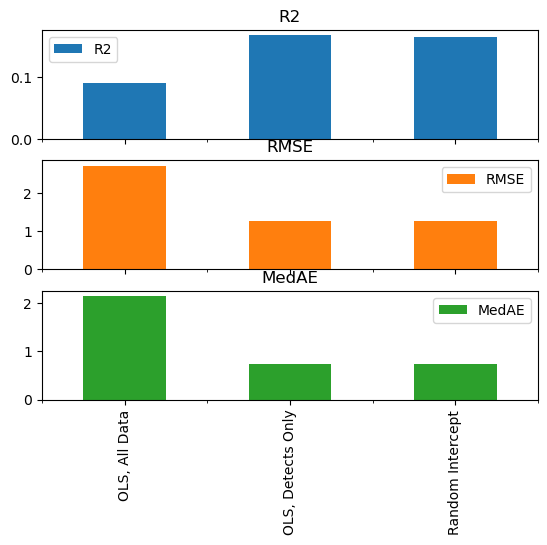

In [31]:
pd.DataFrame(mean_scores).T.plot.bar(subplots=True)

In [32]:
# Add POD model performance, summarize
for k, v in mean_scores.items():
    print(k)
    print(v)

OLS, All Data
R2       0.090850
RMSE     2.730618
MedAE    2.145586
dtype: float64
OLS, Detects Only
R2       0.168187
RMSE     1.273928
MedAE    0.731100
dtype: float64
Random Intercept
R2       0.165176
RMSE     1.276335
MedAE    0.730236
dtype: float64


In [33]:
np.mean(iccs)

0.21164285032378577

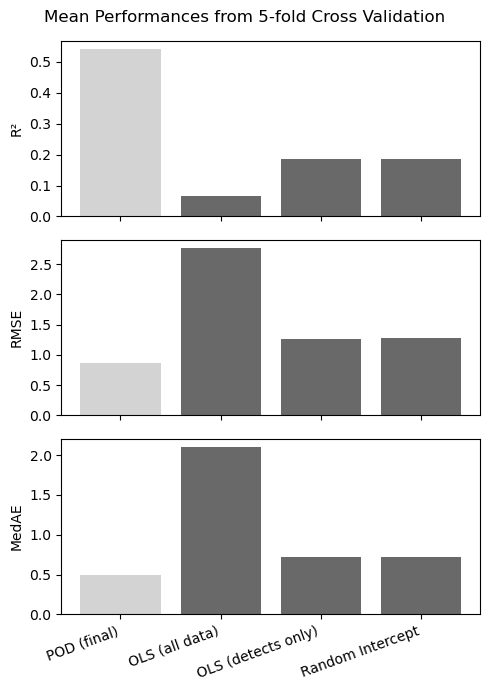

In [34]:
model_names = ["POD (final)", "OLS (all data)", "OLS (detects only)", "Random Intercept"]
r2_scores = [0.54, 0.064673, 0.185991, 0.184203]
rmse_scores = [0.87, 2.761701, 1.270186, 1.271493]
medae_scores = [0.50, 2.097599, 0.720224, 0.715069]

colors = ["lightgrey", "dimgrey", "dimgrey", "dimgrey"]

fig, axes = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

titles = ["R²", "RMSE", "MedAE"]

metrics = [r2_scores, rmse_scores, medae_scores]

for ax, metric, title in zip(axes, metrics, titles):
    ax.bar(model_names, metric, color=colors)
    # ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=20, ha="right")

fig.suptitle('Mean Performances from 5-fold Cross Validation')
plt.tight_layout()
plt.show()